# Analysis of Subsequent Memory Data

This notebook performs analyses for a subsequent memory task conducted with infants, and recreates the figures in the manuscript. It uses preprocessed fMRI data, assumed to be saved in `data/SubMem/`.

Note: p values (and z-scores created through bootstrapping or randomization) may differ from those reported in the manuscript because of random seeds.

**Table of Contents**

[Participant summary information](#participant)    
[Looking behavior](#behavior)    
[Hippocampus segmentation](#segmentation)  
[Main results](#main)
 > [Hippocampus results](#hpc_results)  
 > [Wholebrain results](#wholebrain)  
 > [Medial temporal lobe results](#mtl_results)   
 > [Brain-behavior relationship](#brainbehav) 

[Additional memory GLMs](#add_glms)  
 > [Category memory results](#cat_mem)    
 > [Memory delay results](#delay_mem)   
 > [Parametric results](#parametric)   
 > [Strong vs. weak preference results](#nondirectional)   
 > [Memory retrieval results](#retrieval)   
  
[Control analyses](#control)     
 > [Partial correlations](#partial_corr)   
 > [HPC variance](#variance)     
 > [Category activation](#category)       
 > [Unique images](#unique)

In [81]:
## Load in everything we need 
import numpy as np
import os
import glob
from ast import literal_eval
import nibabel as nb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
from scipy import stats
from scipy.io import loadmat
import matplotlib
import pandas as pd
from nilearn import plotting
import nibabel as nib
from nilearn.input_data import NiftiMasker
import itertools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [2]:
# Get the base directory
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir) # Come back

# Set the data directories
behav_dir =  base_dir + 'data/SubMem/looking_behavior/'
zstat_dir =  base_dir + 'data/SubMem/contrast_maps/'
randomise_dir =  base_dir + 'data/SubMem/randomise/'
standard_hpc_dir =  base_dir + 'data/SubMem/segmentations_standard/'
native_hpc_dir =  base_dir + 'data/SubMem/segmentations_native/'
other_roi_dir =  base_dir + 'data/SubMem/masks/'
save_plot_dir = base_dir + 'data/SubMem/plots/'

# set the colors :) 
color_dict=dict({'left_hpc':'darkturquoise','right_hpc':'cadetblue','left_mtl':'darkorchid','right_mtl':'orchid',
                'hpc':'darkturquoise','mtl':'darkorchid','ant_hpc':'lightskyblue','post_hpc':'cornflowerblue',
                'bilateral_FFA':'indianred','bilateral_OOA':'navy','bilateral_PPA':'mediumseagreen'})


In [3]:
### Define all the functions used in this notebook 

def bootstrap_mean(data,null_vall=0,nPerm=1000):
    '''Bootstrap resampling for the mean of the data'''
    
    perm_dist=[]
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(len(data)),len(data),replace=True)
        randomsamp=np.array(data)[sampidx]
        perm_dist.append(np.nanmean(randomsamp))
    
    # calculate 2 way pval
    if np.nanmean(data) < null_vall:
        pval=np.sum(np.array(perm_dist)>null_vall)/nPerm*2
    else:
        pval=np.sum(np.array(perm_dist)<null_vall)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
    
    CIs =[np.percentile(perm_dist, 2.5), np.percentile(perm_dist, 97.5)]
          
    return pval, CIs

def bootstrap_corr(x_data,y_data,nPerm=1000,model=stats.pearsonr):
    '''Bootstrap resampling for the correlation between two variables'''
    
    corr_dist=[]
    
    # Occasionally may have NaNs so need to leave them out if true
    if sum(np.isnan(np.array(x_data))) > 0:
        print('X data contains %s NaNs' %(sum(np.isnan(np.array(x_data)))))
    if sum(np.isnan(np.array(y_data))) > 0:
        print('Y data contains %s NaNs' %(sum(np.isnan(np.array(y_data)))))       
    
    not_nan=np.where(~np.isnan(np.array(x_data))*~np.isnan(np.array(y_data)))[0]
    x_data=np.array(x_data)[not_nan]
    y_data=np.array(y_data)[not_nan]
    
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(x_data.shape[0]),x_data.shape[0],replace=True)
        random_x=np.array(x_data)[sampidx]
        random_y=np.array(y_data)[sampidx]
        rval, pval=model(random_x,random_y)
        corr_dist.append(rval)
    
    # calculate 2 way pval
    if model(x_data,y_data)[0] < 0:
        pval=np.sum(np.array(corr_dist)>=0)/nPerm*2
    else:
        pval=np.sum(np.array(corr_dist)<=0)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
        
    CIs =[np.percentile(corr_dist, 2.5), np.percentile(corr_dist, 97.5)]
          
    return pval, CIs

def randomise_diff_2sample(data_1, data_2, resample_num=1000):        
    '''Bootstrap resampling independent samples. 
    Take N samples with replacement from each group separately, average within group and then subtract. 
    Do this X times and report the p value of the number of samples in the opposite direction 
    from the true effect'''
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.nanmean(data_1[sub_idx_1]) - np.nanmean(data_2[sub_idx_2])]
    
    # calculate the 2 way p value
    p_val = (1 - ((np.nansum(np.asarray(resample_diff) > 0)) / (resample_num))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.nanmean(data_1) - np.nanmean(data_2)
    
    return p_val, mean_diff, CIs

def bootstrap_partial_corr(x,y,covar,nPerm=1000):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling
    for the remaining variables in C.

    """
        
    # Occasionally may have NaNs so need to leave them out if true
    if sum(np.isnan(np.array(x))) > 0:
        print('X data contains %s NaNs' %(sum(np.isnan(np.array(x)))))
    if sum(np.isnan(np.array(y))) > 0:
        print('Y data contains %s NaNs' %(sum(np.isnan(np.array(y)))))       
    if sum(np.isnan(np.array(covar))) > 0:
        print('Covar data contains %s NaNs' %(sum(np.isnan(np.array(covar)))))  
    
    # get rid of NaNs
    not_nan=np.where(~np.isnan(np.array(x))*~np.isnan(np.array(y))*~np.isnan(np.array(covar)))[0]
    x=np.array(x)[not_nan]
    y=np.array(y)[not_nan]
    covar=np.array(covar)[not_nan]   
        
    corr_dist=[]
                     
    for perm in range(nPerm):
        # get a sample 
        sampidx=np.random.choice(np.arange(x.shape[0]),x.shape[0],replace=True)
        random_x=np.array(x)[sampidx]
        random_y=np.array(y)[sampidx]
        random_covar=np.array(covar)[sampidx]
        
        # Find the x resids
        slope, intercept, r_value, p_value, std_err = stats.linregress(random_covar,random_x)
        resids_xcovar=random_x-(random_covar*slope+intercept)

        # Find the y resids
        slope, intercept, r_value, p_value, std_err = stats.linregress(random_covar,random_y)
        resids_ycovar=random_y-(random_covar*slope+intercept)

        # Finally, get the resids corr
        slope, intercept, r_value, p_value, std_err = stats.linregress(resids_xcovar,resids_ycovar)

        # append the correlation
        corr_dist.append(r_value)
        
    if stats.pearsonr(x,y)[0] < 0:
        pval=np.sum(np.array(corr_dist)>=0)/nPerm
    else:
        pval=np.sum(np.array(corr_dist)<=0)/nPerm
        
    CIs =[np.percentile(corr_dist, 2.5), np.percentile(corr_dist, 97.5)]
          
    # get the actual partial correlation as well  
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,x)
    resids_xcovar=x-(covar*slope+intercept)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,y)
    resids_ycovar=y-(covar*slope+intercept)

    slope, intercept, r_value, p_value, std_err = stats.linregress(resids_xcovar,resids_ycovar)

    return r_value, pval, CIs

def draw_sig(pval,num_comp,xpos,ypos):
    '''Draw significance stars on a plot based on the pval and whether to correct for multiple comparisons'''
    if pval<0.001/num_comp:
        text='***'
    elif pval<0.01/num_comp:
        text='**'
    elif pval<0.05/num_comp:
        text='*'
    elif pval<0.1/num_comp:
        text='~'
    else:
        text=''
            
    plt.annotate(text,(xpos,ypos),fontsize=14)
    
def get_condition_labels(condition):
    '''Get the labels for the zstat contrasts based on the condition we are in'''
    # Unfortunately this is all hard-coded but can be verified by examining the FSF files for 
    # each condition 
    if condition=='Task':
        labels=['All> GIF','Face > GIF','Object > GIF',
                'Place > GIF','Face > Object','Face > Place','Place > Object']
    
    elif condition=='Binary' or condition=='Binary_Unique':
        labels=['Nov > GIF','Fam > GIF','Test > GIF',
                'Fam > Nov','Nov > Test','Fam > Test','Nov+Fam > Test']
    
    elif condition=='Parametric':
        labels=['Familiarity','Main Effect','VPC']
    
    elif condition=='Binary_Categories':
        labels=['Nov > GIF all','Fam > GIF all','Test > GIF all',
                'Fam > Nov all','Fam > Nov face','Fam > Nov object','Fam > Nov place',
               'Nov face > Nov object','Nov face > Nov place','Nov object > Nov place',
               'Fam face > Fam object','Fam face > Fam place','Fam object > Fam place']
                
    elif condition=='Binary_DelayLength':
        labels=['Nov > GIF all','Fam > GIF all','Test > GIF ',
                'Fam > Nov all','Fam > Nov short','Fam > Nov long',
                'Fam short > Fam long','Nov short > Nov long'] 
        
    elif condition=='Binary_Retrieval':
        labels=['Nov Test > GIF','Fam Test > GIF','Encode > GIF',
                'Fam Test > Nov Test','Nov Test > Encode','Fam Test > Encode','Nov+Fam Test > Encode']
    
    elif condition=='Parametric_Retrieval':
        labels=['Familiarity Test','Main Effect Test','Encoding']

    elif condition=='LowHighPref':
        labels=['Low Pref > GIF','High Pref > GIF','Test > GIF',
                'High Pref > Low Pref','Low Pref > Test','High Pref > Test','Low+High Pref > Test']
    
    elif condition=='Control':
        labels=['Encode > GIF','Test > GIF','Test > Encode']     
    
    else:
        print('ERROR: not a valid condition label')
        
    return labels

def plot_wholebrain(condition,zstat,thr_type,tstat_thresh,coords,suffix):
    '''Given a condition, zstat contrast, threshold type, and group, plot whole brain results'''
    labels=get_condition_labels(condition) # what contrasts are relevant to this condition?   
        
    results_path='%s/%s/' % (randomise_dir,condition) # where the files live

    # load the contrast file 
    contrast_nii='%s/zstat%s_%s_%s.nii.gz'%(results_path,zstat,suffix,thr_type)
    nii=nib.load(contrast_nii)

    # change the threshold / color if we are using a corrected 1-p value map 
    if 'corrp' not in thr_type:
        thresh=tstat_thresh 
        vmax=6
        cm='winter'
    else:
        thresh=0.95
        vmax=1
        cm='autumn_r'

    # Plot the whole brain results
    fig=plotting.plot_stat_map(nii,threshold=thresh,cut_coords=coords,vmax=vmax, annotate=True, colorbar=True,
                               draw_cross=False, title='%s - %s'%(suffix,labels[int(zstat)-1]),
                              cmap=cm)
    plotting.show()
    return nii, fig

def hpc_results(condition,zstat):
    '''Given a condition and a zstat contrast, load the 
    individual subjects data and mask results by the whole hippocampus and whole MTL'''
    
    # get the contrast labels
    labels=get_condition_labels(condition)
    
    print('Running analysis for contrast: %s' %(labels[zstat-1]))
    
    # preset an array of shape subs by number of regions (left and right hpc and mtl)
    zstat_results=np.zeros((len(df.Ppt),4)) 

    # for each subject
    for s, sub in enumerate(df.Ppt):
        
        try:
            # get the zstat data
            zstat_data=nib.load('%s/%s/%s_zstat%d_registered_standard.nii.gz' %(zstat_dir,condition,sub,zstat))

            # cycle through the ROIs 
            for r, roi in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']):
                # load the participant specific segmentation 
                segmentation=nib.load('%s/%s_%s.nii.gz'%(standard_hpc_dir,sub,roi))

                # get the values just in this ROI
                zstat_roi=zstat_data.get_fdata()[segmentation.get_fdata()==1]
                
                # average values across the ROI 
                zstat_results[s,r]=np.nanmean(zstat_roi)
        except:
            zstat_results[s,:]=np.nan
            
    # Put hpc and mtl together
    hpc=zstat_results[:,[i for i,x in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']) if 'hpc' in x]]
    mtl=zstat_results[:,[i for i,x in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']) if 'mtl' in x]]
    
    return hpc, mtl

def hpc_ant_post_results(condition,zstat):
    '''Given a condition and a zstat contrast, load the 
    individual subjects data and mask results by the anterior and posterior hippocampus'''
  
    # get the contrast labels
    labels=get_condition_labels(condition)
    
    # preset an array of shape num subs by number of regions (left post, left ant, right post, right ant)
    zstat_results=np.zeros((len(df.Ppt),4))

    # for each subject
    for s, sub in enumerate(df.Ppt):
        
        # get the zstat data
        zstat_data=nib.load('%s/%s/%s_zstat%d_registered_standard.nii.gz' %(zstat_dir,condition,sub,zstat))

        i=0
        
        # these masks have two values - 1 for post and 2 for ant
        for val in range(1,3):
            
            # cycle through left and right 
            for roi in ['left_hpc-TY_ant','right_hpc-TY_ant']:
               
                # load the participant specific segmentation 
                segmentation=nib.load('%s/%s_%s.nii.gz'%(standard_hpc_dir,sub,roi))

                # get the values just in this ROI
                zstat_roi=zstat_data.get_fdata()[segmentation.get_fdata()==val]

                # average values across the ROI 
                zstat_results[s,i]=np.nanmean(zstat_roi)    

                i=i+1
                
    # Put ant_hpc and post_hpc together
    ant_hpc=zstat_results[:,[2,3]]
    post_hpc=zstat_results[:,[0,1]]    
    
    return ant_hpc, post_hpc

def hpc_resids_analysis():
    '''Load in the residual files from the control analysis and mask by the hippocampus'''
    
    # preset an array of shape num subs by number of regions (left and right hpc and mtl)
    resids_results=np.zeros((len(df.Ppt),4)) 

    # for each subject
    for s, sub in enumerate(df.Ppt):
        
        # get the resid data
        resid_data=nib.load('%s/%s/%s_sigmasquareds_registered_standard.nii.gz' %(zstat_dir,'Control',sub))

        for r, roi in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']):
            # load the participant specific segmentation 
            segmentation=nib.load('%s/%s_%s.nii.gz'%(standard_hpc_dir,sub,roi))

            # get the values just in this ROI
            resid_roi=resid_data.get_fdata()[segmentation.get_fdata()==1]

            # average values across the ROI 
            resids_results[s,r]=np.nanmean(resid_roi)

    # Put hpc and mtl together
    resid_hpc=resids_results[:,[i for i,x in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']) if 'hpc' in x]]
    resid_mtl=resids_results[:,[i for i,x in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']) if 'mtl' in x]]
    
    return resid_hpc, resid_mtl

def other_roi_results(condition,zstat,roi_name='bilateral_FFA'):
    '''Given a condition and a zstat contrast, load the 
    individual subjects data and mask results for a standard region of interest like FFA'''
  
    # get the contrast labels
    labels=get_condition_labels(condition)
    
    print('Running analysis for contrast: %s' %(labels[zstat-1]))
    
    # preset
    zstat_results=np.zeros((len(df.Ppt)))
    
    # get the roi mask and intersect (note that these ROIs aren't subject specific!)
    roi_mask=nib.load('%s/%s.nii.gz'%(other_roi_dir,roi_name))
    intersect_mask=nib.load('%s/intersect_mask_standard.nii.gz'%(other_roi_dir))
    intersect_roi=roi_mask.get_fdata()*intersect_mask.get_data()
    
    # for each subject
    for s, sub in enumerate(df.Ppt):
        
        try:
            # get the zstat data
            zstat_data=nib.load('%s/%s/%s_zstat%d_registered_standard.nii.gz' %(zstat_dir,condition,sub,zstat))
            
            # mask by the roi
            zstat_roi=zstat_data.get_fdata()[intersect_roi==1]
        
            # average values across the ROI  
            zstat_results[s]=np.nanmean(zstat_roi)
        except:
            zstat_results[s]=np.nan
            
    return zstat_results

def plot_roi_results(roi_array,roi_name='hpc',condition='Binary',zstat=4):
    '''Plot results and report statistics for ROI analyses at the group level and across ages'''
    
    # get the contrast labels
    labels=get_condition_labels(condition)
    
    print('Plotting contrast: %s' %(labels[zstat-1]))
    
    ### First let's plot the overall effect across subjects 
    fig1=plt.figure(figsize=(3,7))

    xvals=np.hstack((np.zeros(len(roi_array))))

    sns.swarmplot(x=xvals,y=np.hstack((roi_array)),dodge=False,
                  color=color_dict[roi_name],size=10,alpha=0.4,edgecolor='black',linewidth=1)
    sns.barplot(x=xvals,y=np.hstack((roi_array)),dodge=False,alpha=0.6,
                color=color_dict[roi_name],ci=None)
    plt.axhline(0,linestyle='dashed',color='k')
    plt.legend([],[], frameon=False)
    plt.xticks([0],[roi_name],fontsize=16)
    plt.ylabel('Z-statistic',fontsize=16)
    plt.yticks(fontsize=16)

    # Also do the stats! 
    p_val, CIs= bootstrap_mean(roi_array)             
    print('%s effect: %0.3f [%0.3f - %0.3f], p=%0.3f' %(roi_name,np.nanmean(roi_array),CIs[0],CIs[1],p_val))

    plt.errorbar(0,np.nanmean(roi_array),yerr=np.vstack((np.nanmean(roi_array)-CIs[0],
                                                   CIs[1]-np.nanmean(roi_array))),color='black')
    plt.ylim(-2.5,2.5)
    draw_sig(p_val,1,0,1.75)
    print()
    
    ### Then let's plot the age effect
    younger_data=np.array(roi_array)[df.Age<np.nanmedian(df.Age)]
    older_data=np.array(roi_array)[df.Age>np.nanmedian(df.Age)]

    xvals=np.hstack((np.zeros(len(younger_data)),np.ones((len(older_data)))))

    fig2=plt.figure(figsize=(3,7))
    sns.swarmplot(x=xvals,y=np.hstack((younger_data,older_data)),hue=xvals,dodge=False,
                  palette=[color_dict[roi_name],color_dict[roi_name]],orient='vertical',
                  size=8,alpha=0.4,edgecolor='black',linewidth=1)
    sns.barplot(x=xvals,y=np.hstack((younger_data,older_data)),hue=xvals,dodge=False,
                palette=[color_dict[roi_name],color_dict[roi_name]],alpha=0.6,orient='vertical',ci=None)

    plt.ylim(-2.5,2.5)

    # stats 
    p_val, CIs= bootstrap_mean(younger_data)             
    print('Mean zstat younger: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(younger_data),
                                                                 CIs[0],CIs[1],p_val))
    draw_sig(p_val,1,0,1.75)
    plt.errorbar(0,np.nanmean(younger_data),yerr=np.vstack((np.nanmean(younger_data)-CIs[0],
                                                           CIs[1]-np.nanmean(younger_data))),color='black')

    p_val, CIs= bootstrap_mean(older_data)     
    print('Mean zstat  older: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(older_data),
                                                                 CIs[0],CIs[1],p_val))
    draw_sig(p_val,1,1,1.75)
    plt.errorbar(1,np.nanmean(older_data),yerr=np.vstack((np.nanmean(older_data)-CIs[0],
                                                         CIs[1]-np.nanmean(older_data))),color='black')

    # stats
    p_val, mean_diff, CIs= randomise_diff_2sample(younger_data,older_data)             
    print('Younger vs. older infants: %0.3f, p=%0.3f' %(mean_diff,p_val))
    draw_sig(p_val,1,0.5,1.9)

    plt.axhline(0,linestyle='dashed',color='k')
    plt.ylabel('Z-statistic',fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks([0,1],['< 12 mo','> 12 mo'],fontsize=16)
    plt.legend([],[], frameon=False)
    print()
    
    ### finally, plot the continuous age effect 
    fig3=plt.figure(figsize=(7,8))
    sns.regplot(df.Age,roi_array,color=color_dict[roi_name],
                scatter_kws={'edgecolor':'black','linewidth':1,'s':120,'alpha':0.6},)
    plt.xlabel('Age (months)',fontsize=16)
    plt.ylabel('Z-statistic',fontsize=16)
    plt.xticks(np.arange(0,28,4),fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(0,28)
    plt.ylim(-1,2)
    plt.axhline(0,linestyle='dashed',color='k')
    plt.axvline(12,linestyle='dashed',color='maroon')
    
    nan_mask=~np.isnan(df.Age)*~np.isnan(roi_array)
   
    rval,_=stats.spearmanr(np.array(df.Age[nan_mask]),roi_array[nan_mask])
    pval,CIs=bootstrap_corr(np.array(df.Age[nan_mask]),roi_array[nan_mask],model=stats.spearmanr)
    print('Age effect: spearman rho =%0.3f [%0.3f - %0.3f], p=%0.3f' %(rval,CIs[0],CIs[1],pval))
    
    return fig1, fig2, fig3


# Summarise the participant data  <a id='participant'></a>
Create a table of the number of blocks included and number of total blocks for each participant in the experiment.

In [4]:
df=pd.read_csv(base_dir + 'data/SubMem/participant_information.csv',
               index_col=0).sort_values('Age').reset_index().drop(columns='index')
df

,Ppt,Age,Sex,prop_TR_included,prop_looking,eye_reliability,num_coders,Encode_Trials,Familiar_Pref,Novel_Pref
0,s3097_2_1,4.2,M,0.731481,0.903222,0.762903,2,21,11,10
1,s6927_1_2,4.5,F,0.985507,0.780611,0.758101,2,21,8,13
2,s0256_1_1,4.9,F,0.862595,0.675769,0.787497,2,24,10,14
3,s3097_2_2,5.4,M,0.890052,0.953355,0.871945,2,27,18,9
4,s1097_1_2,5.8,F,0.948980,0.820166,0.774241,2,23,10,13
5,s4258_1_2,6.0,F,0.990854,0.721155,0.813598,2,25,10,15
6,s0206_1_2,6.7,F,0.988930,0.855380,0.755024,2,32,17,15
7,s2097_1_2,7.0,M,0.916168,0.946851,0.831273,2,22,9,13
8,s6256_1_1,7.7,M,0.804734,0.696084,0.822000,2,22,11,11
9,s4986_1_1,8.0,M,0.948718,0.901948,0.709000,3,25,15,10


In [5]:
# report some useful metrics 
for col in ['prop_TR_included','prop_looking','eye_reliability','Encode_Trials']:
    print('%s: M=%0.3f, SD=%0.3f; range: %0.3f -- %0.3f' % (col,np.mean(df[col]),np.std(df[col]), 
                                                            np.min(df[col]), np.max(df[col])))

prop_TR_included: M=0.925, SD=0.088; range: 0.725 -- 1.000
prop_looking: M=0.833, SD=0.080; range: 0.676 -- 0.953
eye_reliability: M=0.833, SD=0.064; range: 0.709 -- 0.935
Encode_Trials: M=24.538, SD=4.924; range: 17.000 -- 36.000


Splitting group at 10.500


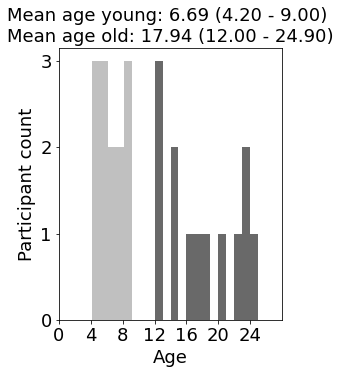

In [6]:
# Now plot the ages 
included_ages=df['Age']

# Split half 
cutoff=np.nanmedian(included_ages)
print('Splitting group at %0.3f' % cutoff)
    
# Plot! 
fig=plt.figure(figsize=(4,5))
younger_ages=included_ages[included_ages<cutoff]
older_ages=included_ages[included_ages>=cutoff]
plt.hist(younger_ages, np.arange(younger_ages.min(), younger_ages.max()+1),color='silver');
plt.hist(older_ages, np.arange(older_ages.min(), older_ages.max()+1),color='dimgrey');
plt.xlabel('Age',fontsize=18)
plt.ylabel('Participant count',fontsize=18)
plt.yticks([0,1,2,3],fontsize=18)
plt.xlim(0,28)
plt.xticks(np.arange(0,28,4),fontsize=18)

plt.title('Mean age young: %0.2f (%0.2f - %0.2f) \nMean age old: %0.2f (%0.2f - %0.2f)' % 
          (younger_ages.mean(), younger_ages.min(), younger_ages.max(), 
           older_ages.mean(),  older_ages.min(), older_ages.max()),fontsize=18)
fig.savefig('%s/age_groups.svg' %(save_plot_dir))

# Looking Behavior <a id='behavior'></a>
How much time did participants spend looking at the novel vs. familiar image during the visual paired comparison test? (Specifically for images that they looked at during encoding, and for trials that are actually used in the fMRI analyses, i.e., low motion)

In [7]:
# preset participant looking behavior
looking_behavior=dict()
prop_encoding_usable=[]

# preset for memorability and image saliency analyses
saliency_cont=dict()
saliency_mat=dict()
saliency_cat=dict()
memorability_cont=dict()

# cycle through participants
for ppt in df.Ppt:
    
    # preset
    looking_behavior[ppt]=dict()
    proportion_fam=[]
    category=[]
    fam_name=[]
    delay=[]
    block_num=[]
    trial_num=[]
    encode_looking_time=[]
    
    # load the data
    data_file = '%s/%s.mat' %(behav_dir,ppt)
    behavior_mat = loadmat(data_file, struct_as_record=False)
    
    # get the vpc idxs
    vpc_idxs=np.where(behavior_mat['isVPC'][0,:])[0]
    
    # how many attempted encoding trials?  
    attempted_trials = len(np.where(behavior_mat['isVPC'][0,:]==0)[0])
    
    # cycle through the vpc indices and get the timing information 
    for vpc_idx in vpc_idxs:
        timecourse=behavior_mat['Timecourse_All'][0][vpc_idx][0]
        trial_onset=behavior_mat['TrialOnsets'][0][vpc_idx][0][0]
        trial_offset=behavior_mat['TrialOffsets'][0][vpc_idx][0][0]
                
        # looking behavior during the stimulus on screen
        stim_timecourse=timecourse[trial_onset:]
        
        # which images were shown? 
        image_fam = behavior_mat['StimNames'][0][vpc_idx][0][0][0].split('/')[-1]
        image_nov = behavior_mat['StimNames'][0][vpc_idx][1][0][0].split('/')[-1]
        
        # what was the delay between this test and the encoding? 
        encode_test_delay=behavior_mat['Encode_VPC_Delay'][0][vpc_idx]
        
        # what was the encode trial?
        encode_trial=behavior_mat['Encode_VPC_Pair'][0][vpc_idx][0]
        
        # find the encode index
        encode_idx=np.where(np.array([f[0] for f in behavior_mat['TrialNames'][0]])==encode_trial)[0][0]
        
        # how much looking was there during the encode trial?
        encode_timecourse=behavior_mat['Timecourse_All'][0][encode_idx][0]
        encode_onset=behavior_mat['TrialOnsets'][0][encode_idx][0][0]
        encode_offset=behavior_mat['TrialOffsets'][0][encode_idx][0][0]
        encode_timecourse_real=encode_timecourse[encode_onset:encode_offset]   
        encode_frame_dur=behavior_mat['MedFrameDur'][0][encode_idx][0][0]
        encode_looking=np.sum(encode_timecourse_real==3)*encode_frame_dur
        
        # which side was the novel side? 
        vpcside=behavior_mat['VPCSide'][0][vpc_idx][0]
        if vpcside=='left':
            fam_num=2
            nov_num=1
        else:
            fam_num=1
            nov_num=2
            
        # calculate proportion looking to each image during test
        looking_fam=np.sum(stim_timecourse==fam_num)/(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))
        looking_nov=np.sum(stim_timecourse==nov_num)/(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))      

        # only add the behavioral data if the encode was useable in fMRI analysis
        if behavior_mat['MotionInclude'][0][encode_idx]==1 and behavior_mat['EyeInclude'][0][encode_idx]==1:
                
            # make sure that the delay was reasonable and they actually looked at the image center
            if encode_test_delay<100 and round(encode_looking,3)>=0.5:
                
                # make sure they looked at the test image too (implied above but just to be sure)
                vpc_frame_dur=behavior_mat['MedFrameDur'][0][vpc_idx][0][0]
                looking_test=(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))*vpc_frame_dur
                
                if round(looking_test,3)>=0.5:
                
                    # save the looking information for the participant 
                    proportion_fam.append(round(looking_fam,3))
                    delay.append(encode_test_delay)
                    category.append(behavior_mat['StimCategory'][0][vpc_idx][0])
                    block_num.append(behavior_mat['TrialNames'][0][encode_idx][0].split('-')[0])
                    trial_num.append(int(behavior_mat['TrialNames'][0][encode_idx][0].split('-')[1].split('_')[-1]))
                    fam_name.append(image_fam)
                    encode_looking_time.append(encode_looking)
                
                    # add the image to the saliency matrix for calculating memorability scores
                    if image_fam not in saliency_mat.keys():
                        saliency_mat[image_fam]=dict()
                        saliency_mat[image_fam][ppt]=looking_fam
                        saliency_cat[image_fam]=behavior_mat['StimCategory'][0][vpc_idx][0]
                    else:
                        saliency_mat[image_fam][ppt]=looking_fam
                    
    looking_behavior[ppt]['prop_fam']=proportion_fam
    looking_behavior[ppt]['category']=category
    looking_behavior[ppt]['delay']=delay  
    looking_behavior[ppt]['encode_block']=block_num  
    looking_behavior[ppt]['encode_trial']=trial_num  
    looking_behavior[ppt]['fam_name']=fam_name
    looking_behavior[ppt]['encode_looking']=encode_looking_time
    
    # save how many encoding trials were usable vs. attempted
    prop_encoding_usable.append(len(proportion_fam)/attempted_trials)

In [82]:
# preset participant looking behavior
looking_behavior=dict()
prop_encoding_usable=[]

# preset for memorability and image saliency analyses
saliency_cont=dict()
saliency_mat=dict()
saliency_cat=dict()
memorability_cont=dict()

# cycle through participants
for ppt in df.Ppt:
    
    # preset
    looking_behavior[ppt]=dict()
    proportion_fam=[]
    category=[]
    fam_name=[]
    delay=[]
    block_num=[]
    trial_num=[]
    encode_looking_time=[]
    total_fam=[]
    
    # load the data
    data_file = '%s/%s.mat' %(behav_dir,ppt)
    behavior_mat = loadmat(data_file, struct_as_record=False)
    
    # get the vpc idxs
    vpc_idxs=np.where(behavior_mat['isVPC'][0,:])[0]
    
    # how many attempted encoding trials?  
    attempted_trials = len(np.where(behavior_mat['isVPC'][0,:]==0)[0])
    
    # cycle through the vpc indices and get the timing information 
    for vpc_idx in vpc_idxs:
        timecourse=behavior_mat['Timecourse_All'][0][vpc_idx][0]
        trial_onset=behavior_mat['TrialOnsets'][0][vpc_idx][0][0]
        trial_offset=behavior_mat['TrialOffsets'][0][vpc_idx][0][0]
                
        # looking behavior during the stimulus on screen
        stim_timecourse=timecourse[trial_onset:]
        
        # which images were shown? 
        image_fam = behavior_mat['StimNames'][0][vpc_idx][0][0][0].split('/')[-1]
        image_nov = behavior_mat['StimNames'][0][vpc_idx][1][0][0].split('/')[-1]
        
        # what was the delay between this test and the encoding? 
        encode_test_delay=behavior_mat['Encode_VPC_Delay'][0][vpc_idx]
        
        # what was the encode trial?
        encode_trial=behavior_mat['Encode_VPC_Pair'][0][vpc_idx][0]
        
        # find the encode index
        encode_idx=np.where(np.array([f[0] for f in behavior_mat['TrialNames'][0]])==encode_trial)[0][0]
        
        # how much looking was there during the encode trial?
        encode_timecourse=behavior_mat['Timecourse_All'][0][encode_idx][0]
        encode_onset=behavior_mat['TrialOnsets'][0][encode_idx][0][0]
        encode_offset=behavior_mat['TrialOffsets'][0][encode_idx][0][0]
        encode_timecourse_real=encode_timecourse[encode_onset:encode_offset]   
        encode_frame_dur=behavior_mat['MedFrameDur'][0][encode_idx][0][0]
        encode_looking=np.sum(encode_timecourse_real==3)*encode_frame_dur
        
        # which side was the novel side? 
        vpcside=behavior_mat['VPCSide'][0][vpc_idx][0]
        if vpcside=='left':
            fam_num=2
            nov_num=1
        else:
            fam_num=1
            nov_num=2
            
        # calculate proportion looking to each image during test
        looking_fam=np.sum(stim_timecourse==fam_num)/(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))
        looking_nov=np.sum(stim_timecourse==nov_num)/(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))      

        # only add the behavioral data if the encode was useable in fMRI analysis
        if behavior_mat['MotionInclude'][0][encode_idx]==1 and behavior_mat['EyeInclude'][0][encode_idx]==1:
                
            # make sure that the delay was reasonable and they actually looked at the image center
            if encode_test_delay<100 and round(encode_looking,3)>=0.5:
                
                # make sure they looked at the test image too (implied above but just to be sure)
                vpc_frame_dur=behavior_mat['MedFrameDur'][0][vpc_idx][0][0]
                looking_test=(np.sum(stim_timecourse==fam_num)+np.sum(stim_timecourse==nov_num))*vpc_frame_dur
                
                if round(looking_test,3)>=0.5:
                
                    # save the looking information for the participant 
                    proportion_fam.append(round(looking_fam,3))
                    delay.append(encode_test_delay)
                    category.append(behavior_mat['StimCategory'][0][vpc_idx][0])
                    block_num.append(behavior_mat['TrialNames'][0][encode_idx][0].split('-')[0])
                    trial_num.append(int(behavior_mat['TrialNames'][0][encode_idx][0].split('-')[1].split('_')[-1]))
                    fam_name.append(image_fam)
                    encode_looking_time.append(encode_looking)
                    total_fam.append(np.sum(stim_timecourse==fam_num))
                
                    # add the image to the saliency matrix for calculating memorability scores
                    if image_fam not in saliency_mat.keys():
                        saliency_mat[image_fam]=dict()
                        saliency_mat[image_fam][ppt]=looking_fam
                        saliency_cat[image_fam]=behavior_mat['StimCategory'][0][vpc_idx][0]
                    else:
                        saliency_mat[image_fam][ppt]=looking_fam
                    
    looking_behavior[ppt]['prop_fam']=proportion_fam
    looking_behavior[ppt]['category']=category
    looking_behavior[ppt]['delay']=delay  
    looking_behavior[ppt]['encode_block']=block_num  
    looking_behavior[ppt]['encode_trial']=trial_num  
    looking_behavior[ppt]['fam_name']=fam_name
    looking_behavior[ppt]['encode_looking']=encode_looking_time
    looking_behavior[ppt]['total_fam']=total_fam
    
    # save how many encoding trials were usable vs. attempted
    prop_encoding_usable.append(len(proportion_fam)/attempted_trials)

### Overall looking behavior 

In [8]:
np.random.seed(0)

# Print the overall average looking time to the familiar

# Binary version --- what proportion of trials did they look more at the familiar (> 50%)
prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])>0.5)/len(looking_behavior[i]['prop_fam']) 
 for i in looking_behavior.keys()]

pval,CIs = bootstrap_mean(prop_fam_binary,null_vall=0.5)
print('Mean proportion looking to familiar (binary):  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(prop_fam_binary),CIs[0],CIs[1],pval))

rval=stats.spearmanr(np.array(df.Age),prop_fam_binary)[0]
pval,CIs=bootstrap_corr(np.array(df.Age),prop_fam_binary,model=stats.spearmanr)
print('Age effect (binary): spearman rho = %0.3f [%0.3f - %0.3f], p=%0.3f' %(rval,CIs[0],CIs[1],pval))

print()

# Continuous version --- what was the average looking to familiar 
prop_fam_cont = [np.nanmean(np.array(looking_behavior[i]['prop_fam'])) 
 for i in looking_behavior.keys()]

pval,CIs = bootstrap_mean(prop_fam_cont,null_vall=0.5)
print('Mean proportion looking to familiar (continuous): M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(prop_fam_cont),CIs[0],CIs[1],pval))

rval=stats.spearmanr(np.array(df.Age),prop_fam_cont)[0]
pval,CIs=bootstrap_corr(np.array(df.Age),prop_fam_cont,model=stats.spearmanr)
print('Age effect (cont): spearman rho = %0.3f [%0.3f - %0.3f], p=%0.3f' %(rval,CIs[0],CIs[1],pval))

Mean proportion looking to familiar (binary):  M = 0.510 [0.473 -- 0.545], p = 0.540
Age effect (binary): spearman rho = 0.220 [-0.239 - 0.572], p=0.306

Mean proportion looking to familiar (continuous): M = 0.494 [0.474 -- 0.514], p = 0.598
Age effect (cont): spearman rho = 0.042 [-0.365 - 0.421], p=0.890


Average familiarity preference in example sub: 0.529


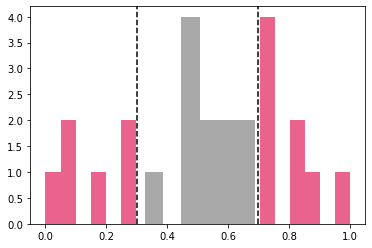

In [9]:
# Show an example subject's looking behavior 
subject_looking=np.array(looking_behavior['s4986_1_1']['prop_fam'])
print('Average familiarity preference in example sub: %0.3f' %np.mean(looking_behavior['s4986_1_1']['prop_fam']))

# Set some cutoff that we can use for looking at strong vs. weak preferences
lower_cutoff=0.3
higher_cutoff=0.7

# Plot a histogram of looking preferences with different colors based on cut offs 
fig = plt.figure()
plt.hist(subject_looking[subject_looking<lower_cutoff],color='#EA638C',bins=6,rwidth=1)
plt.hist(subject_looking[(subject_looking>lower_cutoff)*(subject_looking<higher_cutoff)],color='darkgrey',
         bins=6,rwidth=1)
plt.hist(subject_looking[subject_looking>0.7],color='#EA638C',bins=6,rwidth=1)

# show the cutoff lines 
plt.axvline(lower_cutoff,linestyle='dashed',color='k')
plt.axvline(higher_cutoff,linestyle='dashed',color='k')

# save 
fig.savefig(save_plot_dir+'example_looking_behavior.svg')

### Breaking down looking behavior by age and item types 

In [10]:
# Check for age effects in older vs. younger infants for binarized looking preferences
pval,CIs = bootstrap_mean(np.array(prop_fam_binary)[df.Age<12],null_vall=0.5)
print('Mean proportion looking to familiar (binary) younger:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(np.array(prop_fam_binary)[df.Age<12]),CIs[0],CIs[1],pval))

pval,CIs = bootstrap_mean(np.array(prop_fam_binary)[df.Age>12],null_vall=0.5)
print('Mean proportion looking to familiar (binary) older:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(np.array(prop_fam_binary)[df.Age>12]),CIs[0],CIs[1],pval))

pval,mean_diff,CIs = randomise_diff_2sample(np.array(prop_fam_binary)[df.Age<12],np.array(prop_fam_binary)[df.Age>12])
print('Difference:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (mean_diff,CIs[0],CIs[1],pval))

print()

# Check for age effects in older vs. younger infants for continuous looking preferences
pval,CIs = bootstrap_mean(np.array(prop_fam_cont)[df.Age<12],null_vall=0.5)
print('Mean proportion looking to familiar (continuous) younger:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(np.array(prop_fam_cont)[df.Age<12]),CIs[0],CIs[1],pval))

pval,CIs = bootstrap_mean(np.array(prop_fam_cont)[df.Age>12],null_vall=0.5)
print('Mean proportion looking to familiar (continuous) older:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (np.nanmean(np.array(prop_fam_cont)[df.Age>12]),CIs[0],CIs[1],pval))

pval,mean_diff,CIs = randomise_diff_2sample(np.array(prop_fam_cont)[df.Age<12],np.array(prop_fam_cont)[df.Age>12])
print('Difference:  M = %0.3f [%0.3f -- %0.3f], p = %0.3f' %
      (mean_diff,CIs[0],CIs[1],pval))

Mean proportion looking to familiar (binary) younger:  M = 0.501 [0.451 -- 0.554], p = 0.962
Mean proportion looking to familiar (binary) older:  M = 0.515 [0.457 -- 0.566], p = 0.558
Difference:  M = -0.014 [-0.087 -- 0.063], p = 0.724

Mean proportion looking to familiar (continuous) younger:  M = 0.500 [0.474 -- 0.528], p = 0.972
Mean proportion looking to familiar (continuous) older:  M = 0.491 [0.460 -- 0.523], p = 0.614
Difference:  M = 0.008 [-0.032 -- 0.049], p = 0.716


In [11]:
np.random.seed(0)

# Does looking preference differ by the category of image? 
categories=['Faces','Objects','Places']

# cycle through categories 
for cat in categories:
    
    # calculate the binary preference by counting the instances of > 0.5 looking to familiar
    prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['category'])==cat]>0.5)/sum(np.array(looking_behavior[i]['category'])==cat) 
     for i in looking_behavior.keys()]

    # report the stats
    pval,CIs = bootstrap_mean(prop_fam_binary,null_vall=0.5)
    print('%s: mean proportion looking to familiar (binary): %0.3f [%0.3f -- %0.3f], p = %0.3f' %
          (cat,np.nanmean(prop_fam_binary),CIs[0],CIs[1],pval))

    # calculate the continuous preference by averaging the actual proportion looking
    prop_fam_cont = [np.nanmean(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['category'])==cat]) 
     for i in looking_behavior.keys()]

    # report the stats 
    pval,CIs = bootstrap_mean(prop_fam_cont,null_vall=0.5)
    print('%s: mean proportion looking to familiar (continuous): %0.3f [%0.3f -- %0.3f], p = %0.3f' %
          (cat,np.nanmean(prop_fam_cont),CIs[0],CIs[1],pval))
    print()

Faces: mean proportion looking to familiar (binary): 0.510 [0.446 -- 0.567], p = 0.692
Faces: mean proportion looking to familiar (continuous): 0.494 [0.465 -- 0.528], p = 0.770

Objects: mean proportion looking to familiar (binary): 0.539 [0.476 -- 0.605], p = 0.218
Objects: mean proportion looking to familiar (continuous): 0.518 [0.489 -- 0.549], p = 0.234

Places: mean proportion looking to familiar (binary): 0.468 [0.412 -- 0.524], p = 0.230
Places: mean proportion looking to familiar (continuous): 0.466 [0.430 -- 0.500], p = 0.046



In [12]:
np.random.seed(0)

# Does looking preference differ by the length of the delay?
for delay in ['Short','Long']:
    
    # calculate binary and continuous preference values when the delay was less than a minute
    if delay=='Short':
        prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['delay'])<60]>0.5)/sum(np.array(looking_behavior[i]['delay'])<60) 
     for i in looking_behavior.keys()]
        prop_fam_cont = [np.nanmean(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['delay'])<60]) 
     for i in looking_behavior.keys()]
    
    # calculate binary and continuous preference values when the delay was more than a minute
    else:
        prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['delay'])>=60]>0.5)/sum(np.array(looking_behavior[i]['delay'])>=60) 
     for i in looking_behavior.keys()]
        prop_fam_cont = [np.nanmean(np.array(looking_behavior[i]['prop_fam'])[np.array(looking_behavior[i]['delay'])>=60]) 
     for i in looking_behavior.keys()]

    # report the stats
    pval,CIs = bootstrap_mean(prop_fam_binary,null_vall=0.5)
    print('%s: mean proportion looking to familiar (binary): %0.3f [%0.3f -- %0.3f], p = %0.3f' %
          (delay,np.nanmean(prop_fam_binary),CIs[0],CIs[1],pval))

    pval,CIs = bootstrap_mean(prop_fam_cont,null_vall=0.5)
    print('%s: mean proportion looking to familiar (continuous): %0.3f [%0.3f -- %0.3f], p = %0.3f' %
          (delay,np.nanmean(prop_fam_cont),CIs[0],CIs[1],pval))
    print()

Short: mean proportion looking to familiar (binary): 0.487 [0.437 -- 0.536], p = 0.572
Short: mean proportion looking to familiar (continuous): 0.483 [0.455 -- 0.510], p = 0.230

Long: mean proportion looking to familiar (binary): 0.528 [0.463 -- 0.596], p = 0.366
Long: mean proportion looking to familiar (continuous): 0.507 [0.471 -- 0.545], p = 0.666



In [13]:
# Simulate the looking preferences of just the older infants 

# set some important variables for simulation -- random seed 
np.random.seed(0)
nPerm=1000
null_vall=0.5
sample_size=26

# what is the data going in? 
prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])>0.5)/len(looking_behavior[i]['prop_fam']) 
 for i in looking_behavior.keys()]

data=np.array(prop_fam_binary)[df.Age>12]

# cycle through permutations 
perm_dist=[]
for perm in range(nPerm):
    sampidx=np.random.choice(np.arange(len(data)),sample_size,replace=True)
    randomsamp=np.array(data)[sampidx]
    perm_dist.append(np.nanmean(randomsamp))

# calculate 2 way pval
if np.nanmean(data) < null_vall:
    pval=np.sum(np.array(perm_dist)>null_vall)/nPerm*2
else:
    pval=np.sum(np.array(perm_dist)<null_vall)/nPerm*2

# If the value is greater than 1 then subtract 2
if pval > 1:
    pval = 2 - pval

CIs =[np.percentile(perm_dist, 2.5), np.percentile(perm_dist, 97.5)]

print('Simulated looking pref for older infants at N = %d' % sample_size)
print('Mean=%0.3f, CIs = [%0.3f - %0.3f], pval=%0.3f' %(np.mean(perm_dist), CIs[0],CIs[1],pval))

Simulated looking pref for older infants at N = 26
Mean=0.515, CIs = [0.476 - 0.548], pval=0.398


### Image saliency and memorability analyses
Now, let's see whether infants looked more at some images over others -- in other words, how much of looking behavior is determined by the stimulus itself? Because the novel images during the VPC are randomized across participants, this analysis tells us how salient and/or memorable a given image is regardless of the testing context. 

In [14]:
# shuffle the keys, just so that the matrix looks a bit more random
# (otherwise there looks to be structure that isn't actually there because of the way we fill in the matrix by ppt)
np.random.seed(0)
temp_keys = list(saliency_mat.keys())
np.random.shuffle(temp_keys)

# just doing some shuffling 
saliency_mat_shuffle = dict()
saliency_cat_shuffle = dict()
for key in temp_keys:
    saliency_mat_shuffle.update({key: saliency_mat[key]})
    saliency_cat_shuffle.update({key: saliency_cat[key]})

In [15]:
## Now let's save the proportion looking values for each item that was seen 
saliency_matrix=np.zeros((len(temp_keys),len(df)))*np.nan # preset as NaNs 
saliency_matrix_bin=np.zeros((len(temp_keys),len(df)))*np.nan # preset as NaNs

# for each item
for k, key in enumerate(saliency_mat_shuffle.keys()):
    vals = saliency_mat_shuffle[key]

    for p, ppt in enumerate(df.Ppt):
        
        # if the participant saw this item at test, save the values 
        if ppt in vals.keys():
            saliency_matrix[k,p]=vals[ppt] # continuous looking preference 
            saliency_matrix_bin[k,p]=vals[ppt] >0.5 # binary looking to familiar 


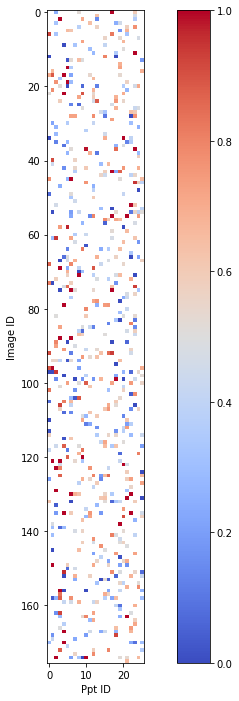

In [16]:
# Plot the results! Color indicates proportion looking to the familiar image, continuously
fig = plt.figure(figsize=(12,12))
plt.imshow(saliency_matrix,cmap='coolwarm')
plt.ylabel('Image ID')
plt.xlabel('Ppt ID')
plt.colorbar()

fig.savefig(save_plot_dir+'item_effects_matrix.svg')

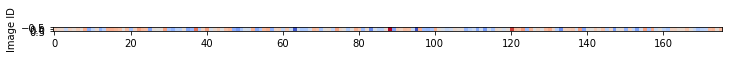

In [17]:
fig = plt.figure(figsize=(12,12))
plt.imshow(np.nanmean(saliency_matrix,axis=1).reshape(1,-1),
           cmap='coolwarm',vmin=0,vmax=1)
plt.ylabel('Image ID')
fig.savefig(save_plot_dir+'item_effects_matrix_avg.svg')

Mean corr in continuous looking across participants: 0.084; pval=0.004
Mean corr in binary looking across participants: 0.021; pval=0.568


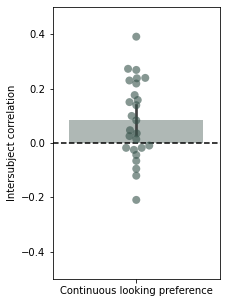

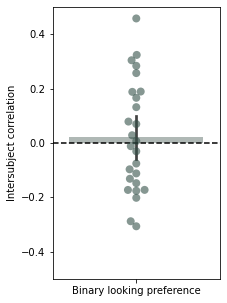

In [18]:
## Let's now characterize similarity across participants by correlating looking preferences
# a single participant is held-out and we are correlating the average looking preference of all other infants with held-out infant

# preset
loo_isc_corrs_cont = np.zeros((saliency_matrix.shape[1]))*np.nan
loo_isc_corrs_bin = np.zeros((saliency_matrix_bin.shape[1]))*np.nan

# cycle through participants
for ppt1 in range(saliency_matrix.shape[1]):
    
    ## continuous version of the analysis
    vals1 = saliency_matrix[:,ppt1] # get participant looking 
    vals2 = np.nanmean(np.delete(saliency_matrix,ppt1,axis=1),axis=1) # get the average looking for all but this participant
        
    # only look at the images that this person saw that were shared with others (NOTE sometimes only one other person saw it)
    items_shared = ~np.isnan(vals1)*~np.isnan(vals2)
           
    # correlate looking preferences 
    rval = stats.pearsonr(vals1[items_shared],vals2[items_shared])[0]
    loo_isc_corrs_cont[ppt1]=rval

    ## binary version of the analyses
    vals1 = saliency_matrix_bin[:,ppt1] # get participant looking 
    vals2 = np.nanmean(np.delete(saliency_matrix_bin,ppt1,axis=1),axis=1) # get the average looking for all but this participant
        
    # only look at the images that this person saw that were shared with others (NOTE sometimes only one other person saw it)
    items_shared = ~np.isnan(vals1)*~np.isnan(vals2)
           
    # correlate looking preferences 
    rval = stats.pearsonr(vals1[items_shared],vals2[items_shared])[0]
    loo_isc_corrs_bin[ppt1]=rval
    
# Now plot the results 
## continuous version 
fig =plt.figure(figsize=(3,5))
corr_df = pd.DataFrame({'corrs':loo_isc_corrs_cont})
sns.swarmplot(data=corr_df,alpha=0.6,size=8,color='#35524A')
sns.barplot(data=corr_df,alpha=0.4,color='#35524A')
plt.axhline(0,linestyle='dashed',color='black')
plt.ylim(-0.5,0.5)
plt.ylabel('Intersubject correlation')
plt.xticks([0],['Continuous looking preference'])

# report the stats and save the figure
np.random.seed(0)
print('Mean corr in continuous looking across participants: %0.3f; pval=%0.3f' %(np.nanmean(loo_isc_corrs_cont),
                                                                                 bootstrap_mean(loo_isc_corrs_cont)[0]))
fig.savefig(save_plot_dir+'loo_isc_behavior_cont.svg')


## binary version 
fig =plt.figure(figsize=(3,5))
corr_df = pd.DataFrame({'corrs':loo_isc_corrs_bin})
sns.swarmplot(data=corr_df,alpha=0.6,size=8,color='#35524A')
sns.barplot(data=corr_df,alpha=0.4,color='#35524A')
plt.ylim(-0.5,0.5)
plt.axhline(0,linestyle='dashed',color='black')
plt.ylabel('Intersubject correlation')
plt.xticks([0],['Binary looking preference'])

# report the stats and save the figure
np.random.seed(0)
print('Mean corr in binary looking across participants: %0.3f; pval=%0.3f' %(np.nanmean(loo_isc_corrs_bin),
                                                                                 bootstrap_mean(loo_isc_corrs_bin)[0]))
fig.savefig(save_plot_dir+'loo_isc_behavior_bin.svg')

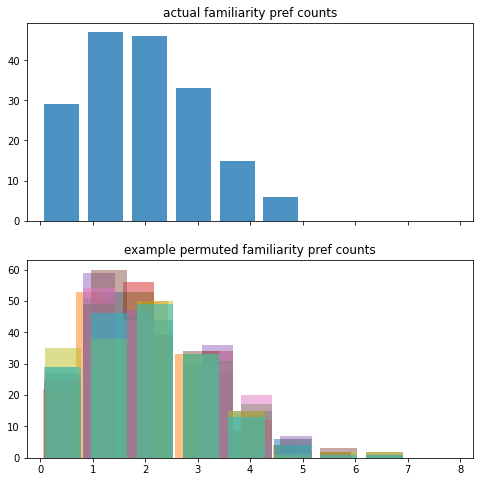

In [19]:
# A different way of looking at this: how many participants would we expect to look more at a given image by chance?
np.random.seed(0)

nPerm = 1000 # number of permutations we will run
chance_fam_counts = np.zeros((len(saliency_matrix),nPerm)) # preset the matrix 

idxs = np.arange(0,len(saliency_matrix_bin)) # a list of indices we can then shuffle

# for each permutation
for p in range(nPerm):
    
    # create a temporary saliency matrix to be used below
    temp_saliency_mat = np.zeros(saliency_matrix_bin.shape)*np.nan
    
    # for each subject
    for sub in range(temp_saliency_mat.shape[1]):
        
        # shuffle their looking preferences (which have already been binarized as fam/novelty preference)
        np.random.shuffle(idxs)
        temp_saliency_mat[:,sub]=saliency_matrix_bin[idxs,sub]
        
    # sum over the participant values to get the chance number of participants who showed a looking preference 
    chance_dist = np.nansum(temp_saliency_mat,axis=1)
    chance_fam_counts[:,p]=chance_dist
    
# Plot the actual familiarity pref counts versus some permutations 
fig, ax=plt.subplots(2,1,figsize=(8,8),sharex=True)

# what were the actual number of images in which X number of participants showed a familiary preference?
actual_fam_prop = np.nansum(saliency_matrix_bin,axis=1)

ax[0].set_title('actual familiarity pref counts')
ax[0].hist(actual_fam_prop,alpha=0.8,bins=6,rwidth=0.8)
ax[1].set_title('example permuted familiarity pref counts')

# Show 10 example permutations -- would be too much to show all 1000! 
for p in range(10):
    ax[1].hist(chance_fam_counts[:,p],alpha=0.5,bins=8,rwidth=0.8)

plt.xlim(-0.25,8.25)

fig.savefig(save_plot_dir+'actual_permuted_pref_counts.svg')

In [20]:
# Let's summarize these results 
all_perc_df=pd.DataFrame()
all_actual=[]

# for each possible number of participants showing a familiarity preference
for poss_val in np.unique(actual_fam_prop):
    
    # how many times did it happen in actuality?
    actual = np.sum(actual_fam_prop == poss_val)/len(saliency_matrix)

    # check how many times this happened across the 1000 permutations
    all_perc = []
    for perm in range(chance_fam_counts.shape[1]):
        permuted = np.sum(chance_fam_counts[:,perm] == poss_val)/len(saliency_matrix)

        all_perc.append(permuted)
    
    # save the porportions
    all_perc_df['%d_infants' %poss_val]=all_perc
    all_actual.append(actual)

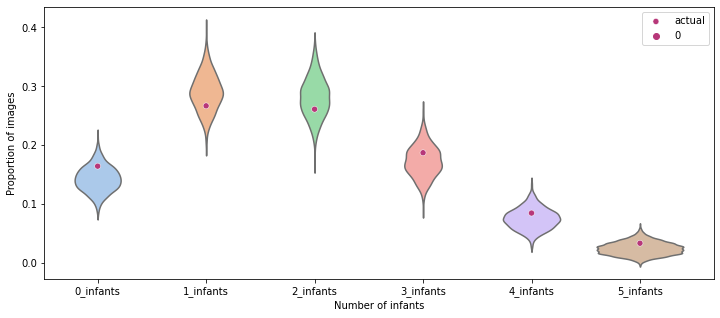

In [21]:
# plot the permuted values as violin plots with actual values as dots to visualize these statistical results 
fig = plt.figure(figsize=(12,5))
sns.violinplot(data=all_perc_df,inner=None,palette='pastel')
sns.scatterplot(data=pd.DataFrame(all_actual),label='actual',palette='magma')
plt.xlabel('Number of infants')
plt.ylabel('Proportion of images')
fig.savefig(save_plot_dir+'actual_permuted_prefs_infant.svg')

In [22]:
# Calculate the statistics by using a chisquare goodness of fit test 
actual_counts=np.array(all_actual)*len(saliency_matrix) # put it back to an integer format 
print('Actual distribution:',actual_counts)

avg_chance_dist = np.array(np.round(np.mean(all_perc_df,axis=0)*len(saliency_matrix))) # round appropriately

# newer versions of scipy have a stricter tolerance for differences in observed and expected distributions
# however, we calculated an empirical chance based on permutations which may not match 
# so before running the test, we will edit the chance distribution accordingly 
if sum(avg_chance_dist) < sum(actual_counts):
    print('Warning: empirical distribution does not sum to the actual distribution, adding to the smallest bin')
    diff_val = sum(actual_counts) - sum(avg_chance_dist) 
    smallest_bin_idx = np.argmin(avg_chance_dist)
    avg_chance_dist[smallest_bin_idx] = avg_chance_dist[smallest_bin_idx]+diff_val
    print('Average chance distribution (rounded and adjusted):',avg_chance_dist)
elif sum(avg_chance_dist) > sum(actual_counts):
    print('Warning: empirical distribution does not sum to the actual distribution, subtracting from the largest bin')
    diff_val = sum(avg_chance_dist) - sum(actual_counts) 
    largest_bin_idx = np.argmax(avg_chance_dist)
    avg_chance_dist[largest_bin_idx] = avg_chance_dist[largest_bin_idx]-diff_val
    print('Average chance distribution (rounded and adjusted):',avg_chance_dist)
else:
    print('Average chance distribution (rounded):',avg_chance_dist)
    
chisq_stat = stats.chisquare(f_obs=actual_counts,f_exp=avg_chance_dist,)
print('\n',chisq_stat)


Actual distribution: [29. 47. 46. 33. 15.  6.]
Average chance distribution (rounded and adjusted): [25. 51. 50. 31. 13.  6.]

 Power_divergenceResult(statistic=1.7104500559529017, pvalue=0.8875806090435006)


### Temporal dependency
Infant looking behavior may also be influenced by order effects -- for instance, do infants consistently show more looking to the familiar item early in a session? 

In [23]:
# Preset 
distance_matrix = []
distance_matrix_bin = []
distance_ids = []
distance_block_bounds = [] 

# they could have seen up to 90 encoding trials, but usually didn't in reality 
# So for visual purposes, we'll cut the matrix a bit short -- this is just because it makes the plot look nicer
total_enc_length=85

# Sort all of the trials by the encoding trial number 
# for each participant
for p, ppt in enumerate(df.Ppt):
    
    # preset 
    temp_distance_matrix =np.zeros((total_enc_length))*np.nan 
    temp_distance_matrix_bin=np.zeros((total_enc_length))*np.nan

    block_stops = [] 
    
    # cycle through the encoding blocks each participant saw 
    for block in np.unique(looking_behavior[ppt]['encode_block']):
        
        # get the looking behavior and the trial numbers
        block_looking = np.array(looking_behavior[ppt]['prop_fam'])[np.array(looking_behavior[ppt]['encode_block'])==block]
        block_trials = np.array(looking_behavior[ppt]['encode_trial'])[np.array(looking_behavior[ppt]['encode_block'])==block]

        # sort the trial numbers 
        sorted_looking = block_looking[np.argsort(block_trials)]
        sorted_trial_nums = block_trials[np.argsort(block_trials)]
        
        # store the looking behavior 
        temp_distance_matrix[sorted_trial_nums-1]=sorted_looking #>0.5
        temp_distance_matrix_bin[sorted_trial_nums-1]=sorted_looking >0.5
        
        # Save when a new block started/stopped as well, in case we want to visualize this
        data_file = '%s/%s.mat' %(behav_dir,ppt)
        behavior_mat = loadmat(data_file, struct_as_record=False)
        last_trial = np.sort([int(val[0].split('_')[-1]) for val 
                              in behavior_mat['TrialNames'][0] if val[0].split('-')[0]==block])[-1]
        block_stops.append(last_trial-1)
        
    # save 
    distance_matrix.append(temp_distance_matrix)
    distance_matrix_bin.append(temp_distance_matrix_bin)
    distance_ids.append('%s-%s' %(ppt,block))
    distance_block_bounds.append(block_stops)
       
# stack this to be a matrix of number of trials by subjects 
distance_matrix = np.vstack((distance_matrix))
distance_matrix_bin = np.vstack((distance_matrix_bin))

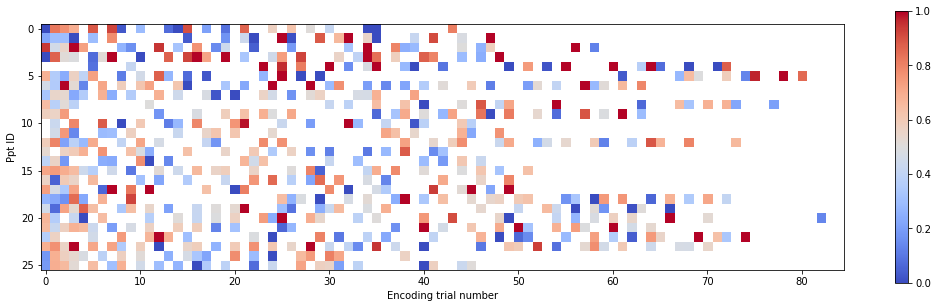

In [24]:
# Plot the looking behavior by trial number 
fig = plt.figure(figsize=(18,5))
plt.imshow(distance_matrix,cmap='coolwarm')
plt.xlabel('Encoding trial number')
plt.ylabel('Ppt ID')
plt.colorbar()

# Mark when the blocks started and stopped 
# for ppt, block_bounds in enumerate(distance_block_bounds):
#     for bound in block_bounds:
#         plt.vlines(bound+0.5,ppt-0.45,ppt+0.45,color='black',linewidth=3,linestyle='solid',)

fig.savefig(save_plot_dir+'infant_temporal_encoding_timecourse.svg')

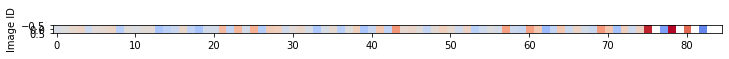

In [25]:
fig = plt.figure(figsize=(12,12))
plt.imshow(np.nanmean(distance_matrix,axis=0).reshape(1,-1),
           cmap='coolwarm',vmin=0,vmax=1)
plt.ylabel('Image ID')
#plt.colorbar()
fig.savefig(save_plot_dir+'infant_temporal_encoding_timecourse_avg.svg')

Mean corr in continuous looking across participants: -0.059; pval=0.128
Mean corr in continuous looking across participants: -0.013; pval=0.794


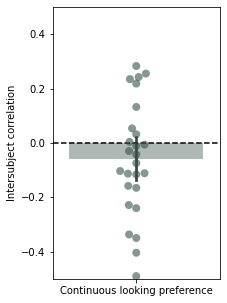

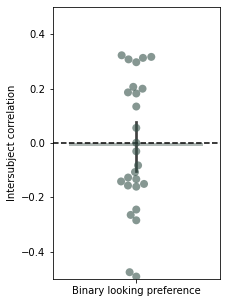

In [26]:
## Let's now characterize similarity across participants by correlating looking preferences (Similar to above)
# a single participant is held-out and we are correlating the average looking preference of all other infants with held-out infant

# preset
loo_isc_corrs_cont = np.zeros((distance_matrix.shape[0]))*np.nan
loo_isc_corrs_bin = np.zeros((distance_matrix.shape[0]))*np.nan

# cycle through participants 
for ppt1 in range(distance_matrix.shape[0]):
    
    ## Continuous version
    vals1 = distance_matrix[ppt1,:] # get the participant looking 
    vals2 = np.nanmean(np.delete(distance_matrix,ppt1,axis=0),axis=0) # get the average looking for all but this participant
        
    # only look at the trials that this person saw that were shared with others (NOTE sometimes only one other person saw it)
    items_shared = ~np.isnan(vals1)*~np.isnan(vals2)
     
    # correlate
    rval = stats.pearsonr(vals1[items_shared],vals2[items_shared])[0]
    loo_isc_corrs_cont[ppt1]=rval
    
    ## Binary version
    vals1 = distance_matrix_bin[ppt1,:] # get the participant looking 
    vals2 = np.nanmean(np.delete(distance_matrix_bin,ppt1,axis=0),axis=0)  # get the average looking for all but this participant
        
    # only look at the trials that this person saw that were shared with others (NOTE sometimes only one other person saw it)
    items_shared = ~np.isnan(vals1)*~np.isnan(vals2)
    
    # correlate
    rval = stats.pearsonr(vals1[items_shared],vals2[items_shared])[0]
    loo_isc_corrs_bin[ppt1]=rval
    
    
## continuous 
fig =plt.figure(figsize=(3,5))
corr_df = pd.DataFrame({'corrs':loo_isc_corrs_cont})
sns.swarmplot(data=corr_df,alpha=0.6,size=8,color='#35524A')
sns.barplot(data=corr_df,alpha=0.4,color='#35524A')
plt.axhline(0,linestyle='dashed',color='black')
plt.ylim(-0.5,0.5)
plt.ylabel('Intersubject correlation')
plt.xticks([0],['Continuous looking preference'])

# report the stats
np.random.seed(0)
print('Mean corr in continuous looking across participants: %0.3f; pval=%0.3f' %(np.nanmean(loo_isc_corrs_cont),
                                                                                 bootstrap_mean(loo_isc_corrs_cont)[0]))

fig.savefig(save_plot_dir+'loo_isc_behavior_temporal_order.svg')

## binary 
fig =plt.figure(figsize=(3,5))
corr_df = pd.DataFrame({'corrs':loo_isc_corrs_bin})
sns.swarmplot(data=corr_df,alpha=0.6,size=8,color='#35524A')
sns.barplot(data=corr_df,alpha=0.4,color='#35524A')
plt.axhline(0,linestyle='dashed',color='black')
plt.ylim(-0.5,0.5)
plt.ylabel('Intersubject correlation')
plt.xticks([0],['Binary looking preference'])

# report the stats
np.random.seed(0)
print('Mean corr in continuous looking across participants: %0.3f; pval=%0.3f' %(np.nanmean(loo_isc_corrs_bin),
                                                                                 bootstrap_mean(loo_isc_corrs_bin)[0]))

fig.savefig(save_plot_dir+'loo_isc_behavior_temporal_order_bin.svg')

# Hippocampus Segmentation <a id='segmentation'></a>
Summarize the size of the hippocampus and medial temporal lobe regions in native space, as created through ASHS. This is more for informative purposes (and also for use in a partial correlation later).  

In [27]:
anat_file = base_dir + 'data/SubMem/hipp_vol_information.csv'

# If this file has already been created, load it in
if os.path.isfile(anat_file):
    print('loaded anatomical file')
    anat_df = pd.read_csv(anat_file, index_col=0)
    
# Else, create the data frame (may take a second to do so!)
else:
    print('creating anatomical summary csv')
    anat_df = pd.DataFrame(columns=['Ppt', 'Age', 'Volume', 'Length', 'Centroid'])

    volumes = []
    lengths = []
    centroids = []

    # cycle through participants
    for ppt in df.Ppt:

        # Loop through the labels
        volume = []
        length = []
        centroid = []

        for mask_name in ['left_hpc','right_hpc','left_mtl','right_mtl']:

            # Load the mask
            mask_nii = nib.load('%s/%s_%s.nii.gz' %(native_hpc_dir,ppt,mask_name))

            # Get the volume of data
            vol = mask_nii.get_fdata()

            # Get the segmented data
            segment = vol == 1

            # What is the volume of this segment 
            # (make sure to multiply by the dimensions of the PETRA scan so it is in mm^3)
            volume += [round(np.sum(segment)*0.9375**3,3)]

            # What is the length
            length += [np.max(np.where(segment == 1)[1])-np.min(np.where(segment == 1)[1])]

            # What is the centroid
            centroid += [np.round(scipy.ndimage.measurements.center_of_mass(segment)).astype('int')]

        # Append the data    
        volumes += [volume]
        lengths += [length]
        centroids += [centroid]

    anat_df['Ppt'] = df.Ppt
    anat_df['Age'] = df.Age
    anat_df['Volume'] = volumes
    anat_df['Length'] = lengths
    anat_df['Centroid'] = centroids

    anat_df

loaded anatomical file


Volume
left_hpc r=0.856, p=0.000
right_hpc r=0.893, p=0.000
left_mtl r=0.650, p=0.000
right_mtl r=0.841, p=0.000

Length
left_hpc r=0.604, p=0.002
right_hpc r=0.574, p=0.002
left_mtl r=0.486, p=0.012
right_mtl r=0.635, p=0.000



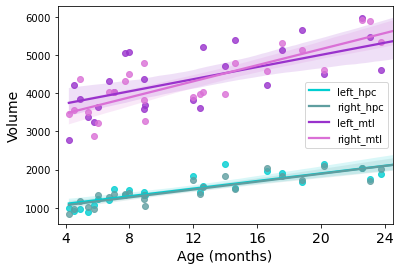

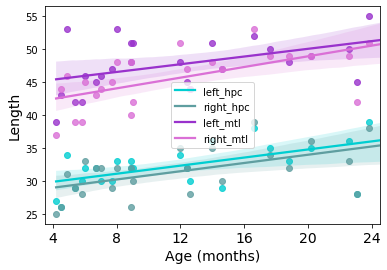

In [29]:
# Plot the volume and length of the different regions 
for data_type in ['Volume','Length']:
    print(data_type)
    fig=plt.figure()
    
    # cycle through ROIs 
    for r, roi in enumerate(['left_hpc','right_hpc','left_mtl','right_mtl']):
        
        # Get the volume of this ROI
        volume = []
        for volumes in anat_df[data_type]:
            volume += [literal_eval(volumes)[r]] # use literal_eval to turn string into array
            
        # Plot the data    
        sns.regplot(x=anat_df['Age'], y=volume,color=color_dict[roi])
        plt.legend(['left_hpc','right_hpc','left_mtl','right_mtl'])#,loc='middle right')
        
        pval,CIs=bootstrap_corr(anat_df['Age'], volume)
        
        mask=~np.isnan(volume)
        print('%s r=%0.3f, p=%0.3f' %(roi,stats.pearsonr(anat_df['Age'][mask], np.array(volume)[mask])[0],pval))
        
    plt.xlabel('Age (months)',fontsize=14)
    plt.xticks(fontsize=14)
    plt.xticks(np.arange(4,28,4),fontsize=14)
    plt.xlim(3.5,24.5)
    plt.ylabel(data_type,fontsize=14)
    print()
    
    fig.savefig('%s/MTL_%s_age.svg' %(save_plot_dir,data_type))

# Main results <a id='main'></a>
Analyze whether there are differences in neural activity during the encoding of items that infants later show a familiarity preference for versus later do not show (using binary looking preferences)

## Hippocampus results <a id='hpc_results'></a>
Analyze both the whole hippocampus (collapsed across hemispheres) and the anterior versus posterior subregions.

In [30]:
# what contrast and z-statistic? 
condition='Binary'
z=4

# Run the analysis (i.e., get the z-stat files for each subject and mask by the hipp and mtl)
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results across hemispheres
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

Running analysis for contrast: Fam > Nov


Plotting contrast: Fam > Nov
hpc effect: 0.295 [0.087 - 0.515], p=0.008

Mean zstat younger: 0.014 [-0.198 - 0.242], p=0.898
Mean zstat  older: 0.577 [0.268 - 0.898], p=0.000
Younger vs. older infants: -0.563, p=0.002

Age effect: spearman rho =0.385 [0.027 - 0.660], p=0.034


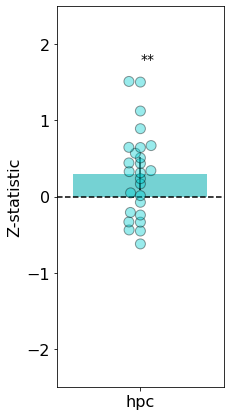

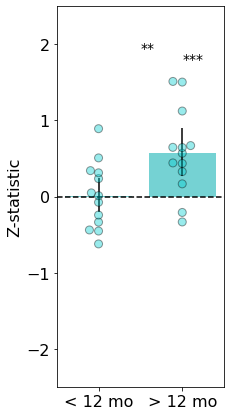

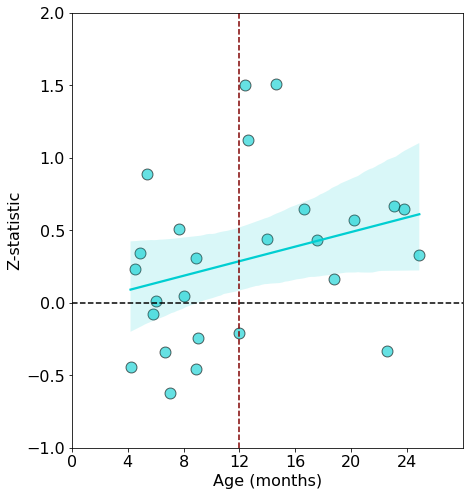

In [31]:
# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

# save the figures
fig1.savefig('%s/%s_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_age.svg' %(save_plot_dir,condition))  

In [32]:
# Now let's look at the subregions of the hpc
# Run the analysis 
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)


Plotting contrast: Fam > Nov
ant_hpc effect: 0.191 [-0.064 - 0.431], p=0.140

Mean zstat younger: -0.076 [-0.360 - 0.240], p=0.652
Mean zstat  older: 0.457 [0.106 - 0.782], p=0.008
Younger vs. older infants: -0.533, p=0.008

Age effect: spearman rho =0.299 [-0.106 - 0.583], p=0.106


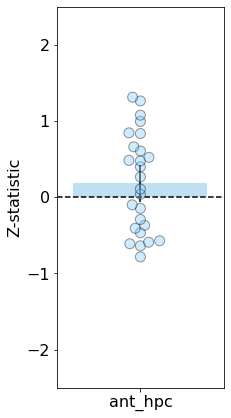

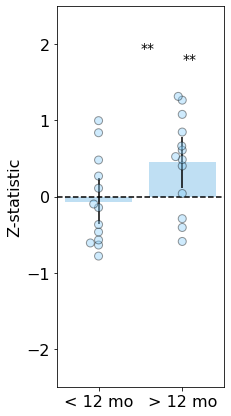

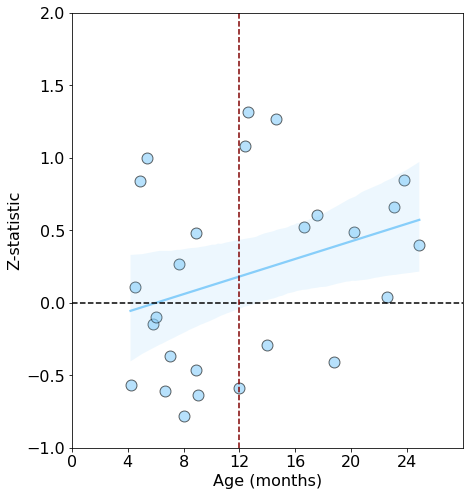

In [33]:
# Set random seed
np.random.seed(0)

# plot the results for ant hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(ant_hpc,roi_name='ant_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_ant_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_ant_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_ant_hpc_age.svg' %(save_plot_dir,condition)) 

Plotting contrast: Fam > Nov
post_hpc effect: 0.369 [0.139 - 0.629], p=0.002

Mean zstat younger: 0.068 [-0.174 - 0.305], p=0.558
Mean zstat  older: 0.670 [0.311 - 1.040], p=0.000
Younger vs. older infants: -0.601, p=0.004

Age effect: spearman rho =0.339 [-0.047 - 0.635], p=0.080


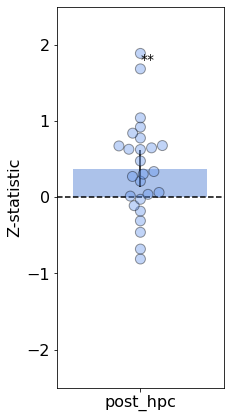

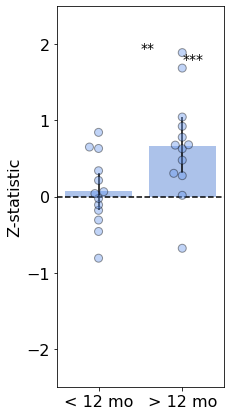

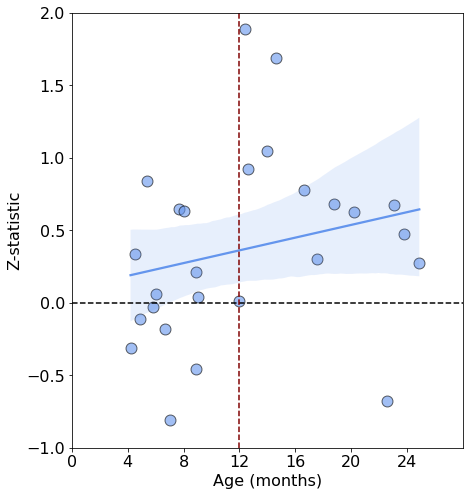

In [34]:
# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(post_hpc,roi_name='post_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_post_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_post_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_post_hpc_age.svg' %(save_plot_dir,condition)) 

In [35]:
# Set random seed 
np.random.seed(0)

# Print any differences between subregions and also age 
print('Mean difference in anterior vs. posterior hpc')
p_val, CIs= bootstrap_mean(post_hpc-ant_hpc)     
print('all subjects: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(post_hpc-ant_hpc),
                                                                 CIs[0],CIs[1],p_val))

p_val, CIs= bootstrap_mean(post_hpc[df.Age<np.nanmedian(df.Age)]-ant_hpc[df.Age<np.nanmedian(df.Age)])     
print('younger subjects: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(post_hpc[df.Age<np.nanmedian(df.Age)]-
                                                                      ant_hpc[df.Age<np.nanmedian(df.Age)]),
                                                                 CIs[0],CIs[1],p_val))

p_val, CIs= bootstrap_mean(post_hpc[df.Age>np.nanmedian(df.Age)]-ant_hpc[df.Age>np.nanmedian(df.Age)])     
print('older subjects: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(post_hpc[df.Age>np.nanmedian(df.Age)]
                                                                    -ant_hpc[df.Age>np.nanmedian(df.Age)]),
                                                                 CIs[0],CIs[1],p_val))

Mean difference in anterior vs. posterior hpc
all subjects: 0.178 [-0.039 - 0.411], p=0.118
younger subjects: 0.144 [-0.143 - 0.450], p=0.362
older subjects: 0.212 [-0.112 - 0.559], p=0.218


## Wholebrain results <a id='wholebrain'></a>
Visualize the results from using FSL randomise to see if memory effects can be found elsewhere in the brain.

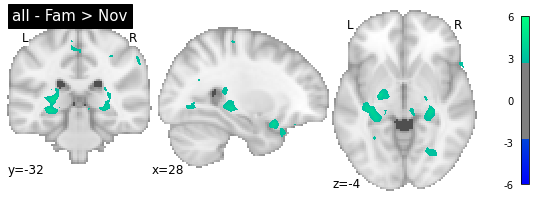

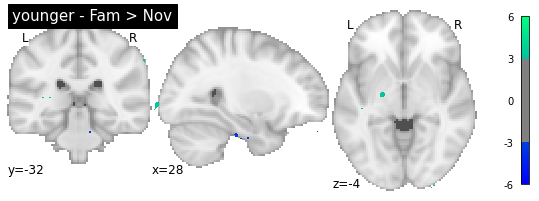

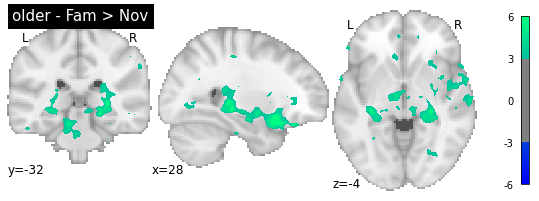

In [36]:
# what contrast and z-statistic? 
condition='Binary'
z=4
coords=(28,-32,-4)

# plot the results across all participants and in subgroups
for suffix in ['all','younger','older']:
    
    if suffix =='all':
        group_thresh =stats.t.ppf(0.995, len(df.Ppt))
    else:
        group_thresh =stats.t.ppf(0.995, len(df.Ppt)/2)

    ## tfce_corrp_tstat1 or vox_corrp_tstat1 or tstat1 or clusterm_corrp_tstat1
    nii,fig=plot_wholebrain(condition,zstat=z,thr_type='tstat1',
                        tstat_thresh=group_thresh,coords=coords,suffix=suffix)
    
    fig.savefig('%s/%s_wholebrain_%s.svg' %(save_plot_dir,condition,suffix))

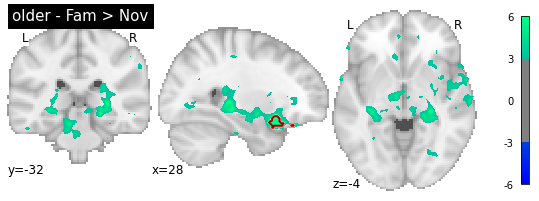

In [37]:
## Now plot with the TFCE-corrected overlay for the older group (TFCE correction only was significant for the older infants)
labels=get_condition_labels(condition)
results_path='%s/%s/' % (randomise_dir,condition)

suffix='older'

nii=nib.load('%s/zstat%s_%s_%s.nii.gz'%(results_path,z,suffix,'tstat1'))
tfce_nii=nib.load('%s/zstat%s_%s_%s.nii.gz'%(results_path,z,suffix,'tfce_corrp_tstat1'))

fig = plotting.plot_stat_map(nii,threshold=group_thresh,
                             cut_coords=coords,vmax=6, annotate=True, colorbar=True,
                                   draw_cross=False, title='%s - %s'%(suffix,labels[int(z)-1]),
                                  cmap='winter')

fig.add_contours(nib.Nifti1Image(tfce_nii.get_fdata()*(tfce_nii.get_fdata()>0.95),
                                 tfce_nii.affine),cmap='Reds')

fig.savefig('%s/%s_wholebrain_tfce_%s.svg' %(save_plot_dir,condition,suffix)) 

## Medial temporal lobe results <a id='mtl_results'></a>
Analyze the whole medial temporal lobe (collapsed across hemispheres and subfields) using the main analysis type

Plotting contrast: Fam > Nov
mtl effect: 0.152 [-0.090 - 0.408], p=0.222

Mean zstat younger: -0.106 [-0.330 - 0.120], p=0.416
Mean zstat  older: 0.409 [0.032 - 0.833], p=0.034
Younger vs. older infants: -0.516, p=0.026

Age effect: spearman rho =0.171 [-0.244 - 0.538], p=0.386


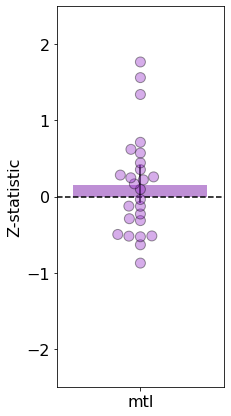

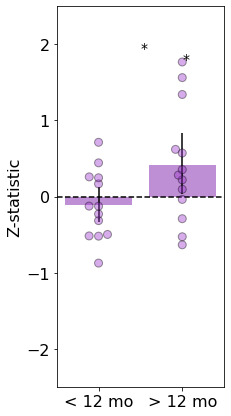

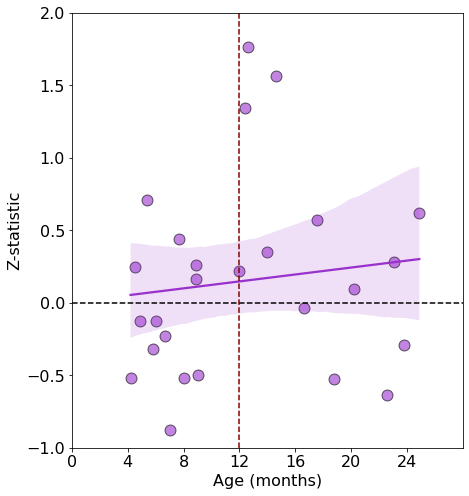

In [38]:
# what contrast and z-statistic? 
condition='Binary'
z=4

# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(mtl,roi_name='mtl',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_mtl_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_mtl_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_mtl_age.svg' %(save_plot_dir,condition)) 

## Brain-behavior relationship <a id='brainbehav'></a>
All of the analyses above were within-subject, but is there a link between individual differences in average familiarity preference and our hippocampal effects? We will conduct a median split of participants to find out. 

In [39]:
# Reload the results 
# what contrast and z-statistic? 
condition='Binary'
z=4

# Run the analysis! 
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results 
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

# reload for the anterior / posterior as well
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)

Running analysis for contrast: Fam > Nov


In [40]:
# Reload the familiarity preferences in case you may have overwritten it above 
prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])>0.5)/len(looking_behavior[i]['prop_fam']) 
 for i in looking_behavior.keys()]
prop_fam_cont = [np.nanmean(np.array(looking_behavior[i]['prop_fam'])) 
 for i in looking_behavior.keys()]

Non-familiarity pref (N=13, M=0.455) vs. Familiarity pref (N=13, M=0.534)
Mean lower median fam pref: 0.173 [-0.124 - 0.491], p=0.276
Mean higher median fam pref: 0.417 [0.117 - 0.705], p=0.000
Low vs. high familiarity pref infants: -0.244, p=0.288


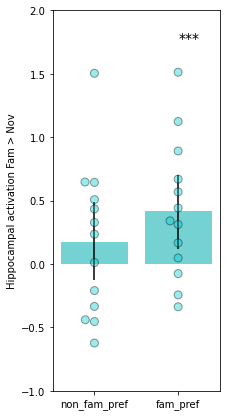

In [41]:
# Run a median split the participants based on their average familiarity preference 
fam_pref_kids = np.array(prop_fam_cont)>np.median(prop_fam_cont)

print('Non-familiarity pref (N=%d, M=%0.3f) vs. Familiarity pref (N=%d, M=%0.3f)'%
      (sum(~fam_pref_kids),np.mean(np.array(prop_fam_cont)[~fam_pref_kids]),
      sum(fam_pref_kids),np.mean(np.array(prop_fam_cont)[fam_pref_kids])))

# set the x-values such that they match the length of each subgroup
xvals=np.hstack((np.zeros(sum(~fam_pref_kids)),np.ones(sum(fam_pref_kids))))

# make a figure
fig = plt.figure(figsize=(3,7))

# now plot the data 
sns.swarmplot(x=xvals,y=np.hstack((hpc[~fam_pref_kids],hpc[fam_pref_kids])),hue=xvals,dodge=False,
              palette=[color_dict['hpc'],color_dict['hpc']],orient='vertical',
              size=8,alpha=0.4,edgecolor='black',linewidth=1)
sns.barplot(x=xvals,y=np.hstack((hpc[~fam_pref_kids],hpc[fam_pref_kids])),hue=xvals,dodge=False,
            palette=[color_dict['hpc'],color_dict['hpc']],alpha=0.6,orient='vertical',ci=None)
plt.xticks([0,1],['non_fam_pref','fam_pref'])
plt.ylabel('Hippocampal activation Fam > Nov')
plt.ylim(-1,2)
plt.legend([],[], frameon=False)

# report some statsitics 
np.random.seed(0)

# stats for lower median
p_val, CIs= bootstrap_mean(hpc[~fam_pref_kids])             
print('Mean lower median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(hpc[~fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,0,1.75)
plt.errorbar(0,np.nanmean(hpc[~fam_pref_kids]),yerr=np.vstack((np.nanmean(hpc[~fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(hpc[~fam_pref_kids]))),color='black')
# stats for higher median 
p_val, CIs= bootstrap_mean(hpc[fam_pref_kids])             
print('Mean higher median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(hpc[fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,1,1.75)
plt.errorbar(1,np.nanmean(hpc[fam_pref_kids]),yerr=np.vstack((np.nanmean(hpc[fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(hpc[fam_pref_kids]))),color='black')
# stats for difference
p_val, mean_diff, CIs= randomise_diff_2sample(hpc[~fam_pref_kids],hpc[fam_pref_kids])             
print('Low vs. high familiarity pref infants: %0.3f, p=%0.3f' %(mean_diff,p_val))
draw_sig(p_val,1,0.5,1.9)

fig.savefig(save_plot_dir+'%s_hpc_median_split_fam_pref.svg' %(condition))

Mean lower median fam pref: 0.138 [-0.149 - 0.421], p=0.318
Mean higher median fam pref: 0.244 [-0.162 - 0.630], p=0.242
Low vs. high familiarity pref infants: -0.107, p=0.708
Mean lower median fam pref: 0.195 [-0.160 - 0.566], p=0.294
Mean higher median fam pref: 0.542 [0.243 - 0.832], p=0.000
Low vs. high familiarity pref infants: -0.347, p=0.162


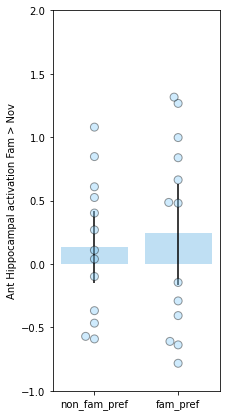

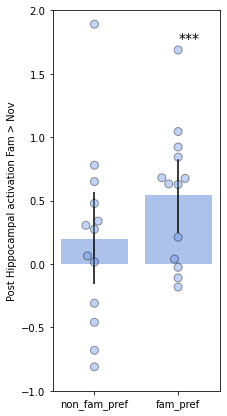

In [42]:
# Run this same analysis for the anterior / posterior hippocampus
# make a figure
fig = plt.figure(figsize=(3,7))

# plot the data 
sns.swarmplot(x=xvals,y=np.hstack((ant_hpc[~fam_pref_kids],ant_hpc[fam_pref_kids])),hue=xvals,dodge=False,
              palette=[color_dict['ant_hpc'],color_dict['ant_hpc']],orient='vertical',
              size=8,alpha=0.4,edgecolor='black',linewidth=1)
sns.barplot(x=xvals,y=np.hstack((ant_hpc[~fam_pref_kids],ant_hpc[fam_pref_kids])),hue=xvals,dodge=False,
            palette=[color_dict['ant_hpc'],color_dict['ant_hpc']],alpha=0.6,orient='vertical',ci=None)
plt.xticks([0,1],['non_fam_pref','fam_pref'])
plt.ylabel('Ant Hippocampal activation Fam > Nov')
plt.ylim(-1,2)
plt.legend([],[], frameon=False)

# report some statsitics 
np.random.seed(0)

# stats for lower median
p_val, CIs= bootstrap_mean(ant_hpc[~fam_pref_kids])             
print('Mean lower median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(ant_hpc[~fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,0,1.75)
plt.errorbar(0,np.nanmean(ant_hpc[~fam_pref_kids]),yerr=np.vstack((np.nanmean(ant_hpc[~fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(ant_hpc[~fam_pref_kids]))),color='black')
# stats for higher median 
p_val, CIs= bootstrap_mean(ant_hpc[fam_pref_kids])             
print('Mean higher median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(ant_hpc[fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,1,1.75)
plt.errorbar(1,np.nanmean(ant_hpc[fam_pref_kids]),yerr=np.vstack((np.nanmean(ant_hpc[fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(ant_hpc[fam_pref_kids]))),color='black')
# stats for difference
p_val, mean_diff, CIs= randomise_diff_2sample(ant_hpc[~fam_pref_kids],ant_hpc[fam_pref_kids])             
print('Low vs. high familiarity pref infants: %0.3f, p=%0.3f' %(mean_diff,p_val))
draw_sig(p_val,1,0.5,1.9)

fig.savefig(save_plot_dir+'%s_ant_hpc_median_split_fam_pref.svg' %(condition))


# make a figure
fig = plt.figure(figsize=(3,7))

# plot the data 
sns.swarmplot(x=xvals,y=np.hstack((post_hpc[~fam_pref_kids],post_hpc[fam_pref_kids])),hue=xvals,dodge=False,
              palette=[color_dict['post_hpc'],color_dict['post_hpc']],orient='vertical',
              size=8,alpha=0.4,edgecolor='black',linewidth=1)
sns.barplot(x=xvals,y=np.hstack((post_hpc[~fam_pref_kids],post_hpc[fam_pref_kids])),hue=xvals,dodge=False,
            palette=[color_dict['post_hpc'],color_dict['post_hpc']],alpha=0.6,orient='vertical',ci=None)
plt.xticks([0,1],['non_fam_pref','fam_pref'])
plt.ylabel('Post Hippocampal activation Fam > Nov')
plt.ylim(-1,2)
plt.legend([],[], frameon=False)

# report some statsitics 
np.random.seed(0)

# stats for lower median
p_val, CIs= bootstrap_mean(post_hpc[~fam_pref_kids])             
print('Mean lower median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(post_hpc[~fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,0,1.75)
plt.errorbar(0,np.nanmean(post_hpc[~fam_pref_kids]),yerr=np.vstack((np.nanmean(post_hpc[~fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(post_hpc[~fam_pref_kids]))),color='black')
# stats for higher median 
p_val, CIs= bootstrap_mean(post_hpc[fam_pref_kids])             
print('Mean higher median fam pref: %0.3f [%0.3f - %0.3f], p=%0.3f' %(np.nanmean(post_hpc[fam_pref_kids]),
                                                             CIs[0],CIs[1],p_val))
draw_sig(p_val,1,1,1.75)
plt.errorbar(1,np.nanmean(post_hpc[fam_pref_kids]),yerr=np.vstack((np.nanmean(post_hpc[fam_pref_kids])-CIs[0],
                                                   CIs[1]-np.nanmean(post_hpc[fam_pref_kids]))),color='black')
# stats for difference
p_val, mean_diff, CIs= randomise_diff_2sample(post_hpc[~fam_pref_kids],post_hpc[fam_pref_kids])             
print('Low vs. high familiarity pref infants: %0.3f, p=%0.3f' %(mean_diff,p_val))
draw_sig(p_val,1,0.5,1.9)

fig.savefig(save_plot_dir+'%s_post_hpc_median_split_fam_pref.svg' %(condition))

# Additional memory GLMs <a id='add_mem'></a>
What are the other ways that we could look at memory encoding in our data?

## Category memory results <a id='cat_mem'></a>
Same as above for the binary familiarity versus novelty looking preference, but now broken down by the image category seen at encoding.

Running analysis for contrast: Fam > Nov face
missing data from 1 participants
Plotting contrast: Fam > Nov face
hpc effect: 0.101 [-0.227 - 0.398], p=0.520

Mean zstat younger: 0.029 [-0.309 - 0.386], p=0.906
Mean zstat  older: 0.180 [-0.344 - 0.619], p=0.458
Younger vs. older infants: -0.151, p=0.604

Age effect: spearman rho =0.176 [-0.271 - 0.582], p=0.406

Running analysis for contrast: Fam > Nov object
missing data from 1 participants
Plotting contrast: Fam > Nov object
hpc effect: 0.265 [-0.033 - 0.558], p=0.082

Mean zstat younger: -0.028 [-0.435 - 0.439], p=0.848
Mean zstat  older: 0.581 [0.301 - 0.899], p=0.000
Younger vs. older infants: -0.609, p=0.028

Age effect: spearman rho =0.389 [0.019 - 0.671], p=0.044

Running analysis for contrast: Fam > Nov place
missing data from 1 participants
Plotting contrast: Fam > Nov place
hpc effect: 0.306 [-0.046 - 0.686], p=0.098

Mean zstat younger: 0.252 [-0.299 - 0.812], p=0.418
Mean zstat  older: 0.365 [-0.053 - 0.783], p=0.084
Younge

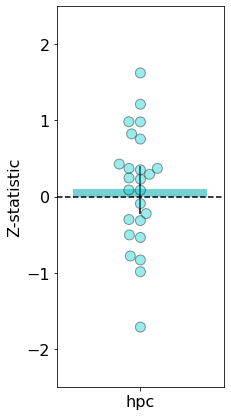

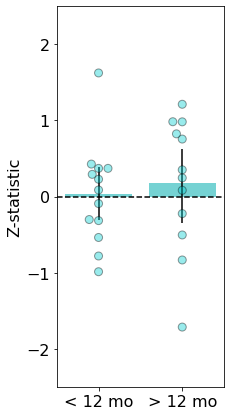

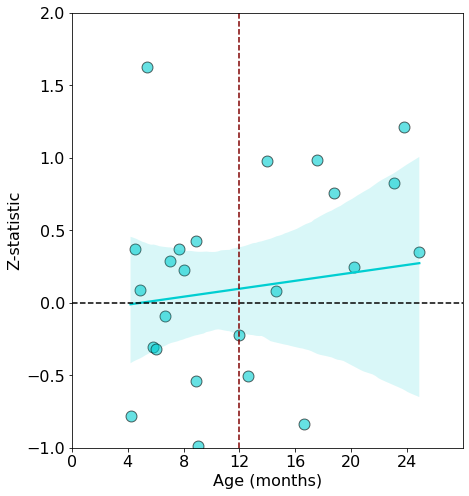

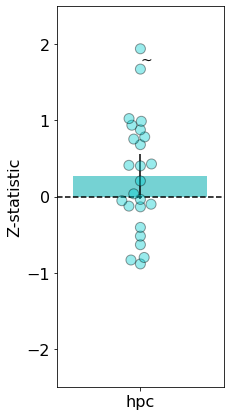

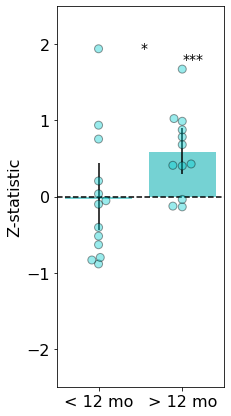

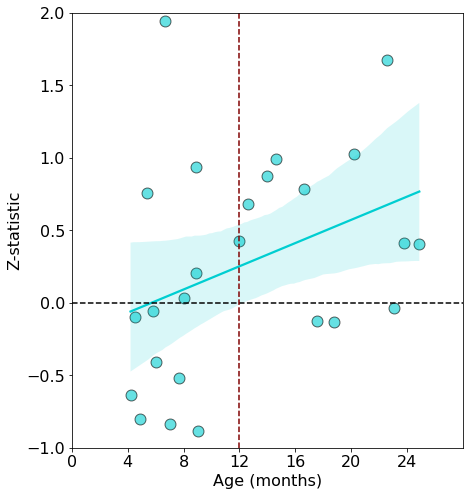

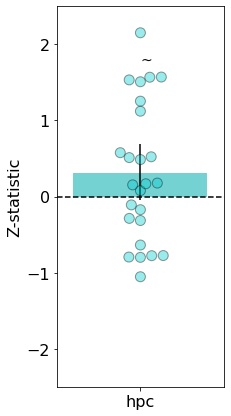

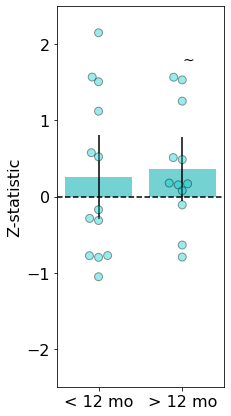

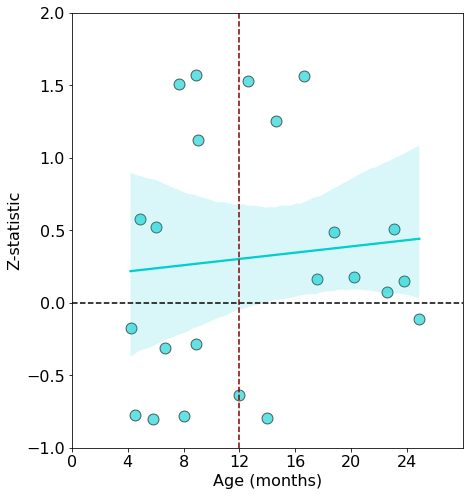

In [45]:
# what contrast and z-statistic? 
condition='Binary_Categories'

for z, cat in zip([5,6,7],['faces','objects','places']):
    
    # Run the analysis! 
    zstat_results=hpc_results(condition=condition,zstat=z)

    # Average the hpc and mtl results 
    hpc=np.nanmean(zstat_results[0],axis=1)
    mtl=np.nanmean(zstat_results[1],axis=1)

    # some participants may not be able to contribute to this analysis 
    print('missing data from %d participants' % sum(np.isnan(hpc)))
    
    # Set random seed
    np.random.seed(0)

    # plot the results for hpc (overall, split half age, continuous age)
    fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

    # save them 
    fig1.savefig('%s/%s_%s_hpc_all_results.svg' %(save_plot_dir,condition,cat))
    fig2.savefig('%s/%s_%s_hpc_split_half.svg' %(save_plot_dir,condition,cat))
    fig3.savefig('%s/%s_%s_hpc_age.svg' %(save_plot_dir,condition,cat))
    print()

## Memory delay results <a id='delay_mem'></a>
Same as above for the binary familiarity versus novelty looking preference, but now broken down by the length of time between encoding and test (short = less than one min, long = longer than one min).

Running analysis for contrast: Fam > Nov short
Plotting contrast: Fam > Nov short
hpc effect: 0.385 [0.029 - 0.747], p=0.036

Mean zstat younger: 0.088 [-0.490 - 0.665], p=0.746
Mean zstat  older: 0.681 [0.383 - 0.994], p=0.000
Younger vs. older infants: -0.593, p=0.086

Age effect: spearman rho =0.345 [-0.039 - 0.641], p=0.070

Running analysis for contrast: Fam > Nov long
Plotting contrast: Fam > Nov long
hpc effect: 0.001 [-0.312 - 0.312], p=0.962

Mean zstat younger: -0.121 [-0.568 - 0.348], p=0.620
Mean zstat  older: 0.122 [-0.270 - 0.554], p=0.532
Younger vs. older infants: -0.243, p=0.416

Age effect: spearman rho =0.019 [-0.376 - 0.407], p=0.938



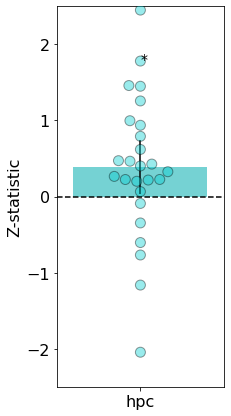

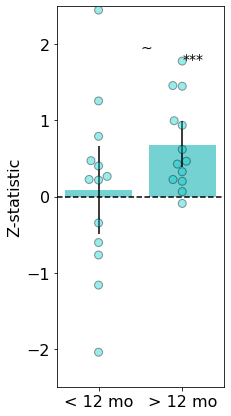

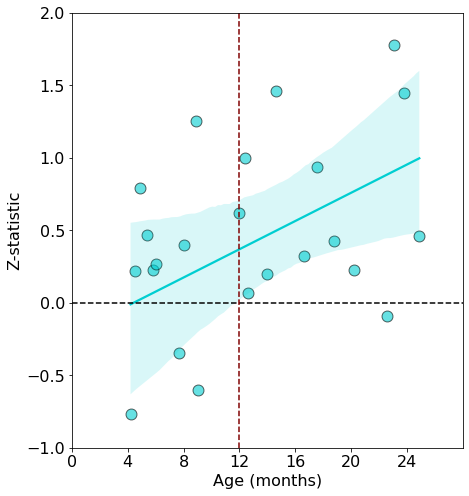

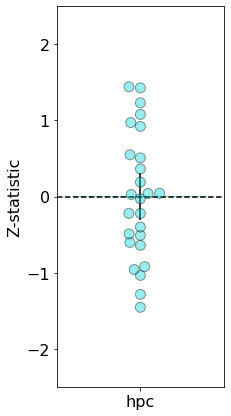

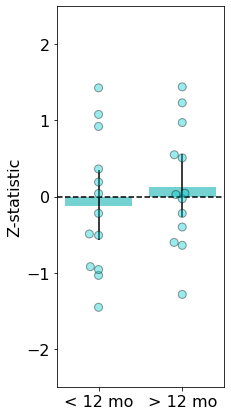

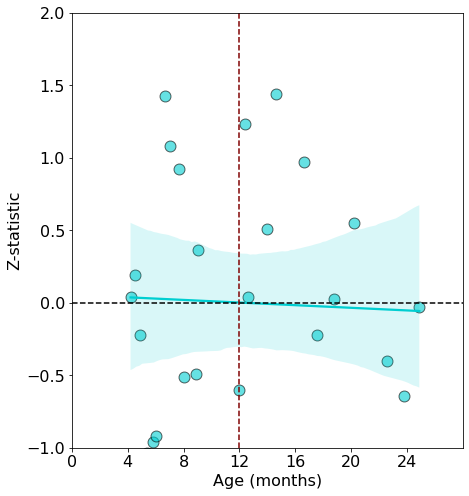

In [46]:
# what contrast and z-statistic? 
condition='Binary_DelayLength'

for z, delay in zip([5,6],['short','long']):
    
    # Run the analysis! 
    zstat_results=hpc_results(condition=condition,zstat=z)

    # Average the hpc and mtl results 
    hpc=np.nanmean(zstat_results[0],axis=1)
    mtl=np.nanmean(zstat_results[1],axis=1)
    
    # Set random seed
    np.random.seed(0)

    # plot the results for hpc (overall, split half age, continuous age)
    fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

    # save them 
    fig1.savefig('%s/%s_%s_hpc_all_results.svg' %(save_plot_dir,condition,delay))
    fig2.savefig('%s/%s_%s_hpc_split_half.svg' %(save_plot_dir,condition,delay))
    fig3.savefig('%s/%s_%s_hpc_age.svg' %(save_plot_dir,condition,delay))  
    print()

## Parametric results <a id='parametric'></a>
Do we get similar results if instead of binarizing looking preference, we look at the amount of looking to the familiar image continuously?

In [47]:
# what contrast and z-statistic? 
condition='Parametric'
z=1

# Run the analysis! 
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results 
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

Running analysis for contrast: Familiarity


Plotting contrast: Familiarity
hpc effect: 0.215 [-0.006 - 0.477], p=0.064

Mean zstat younger: -0.016 [-0.283 - 0.266], p=0.930
Mean zstat  older: 0.447 [0.091 - 0.840], p=0.012
Younger vs. older infants: -0.463, p=0.028

Age effect: spearman rho =0.237 [-0.132 - 0.573], p=0.184


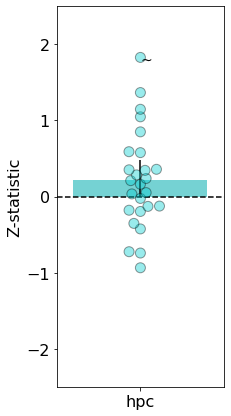

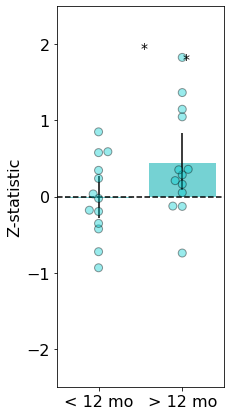

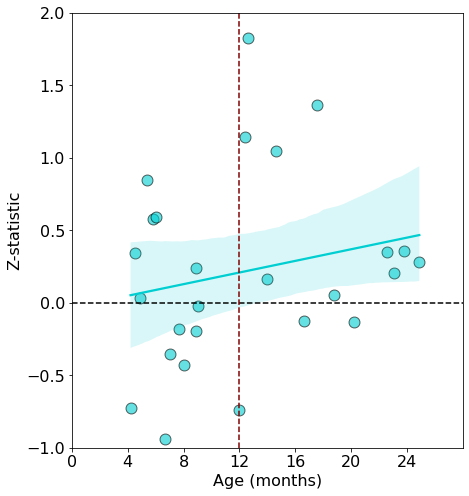

In [48]:
# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_age.svg' %(save_plot_dir,condition))  

In [49]:
# Now let's look at the subregions of the hpc
# Run the analysis 
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)


Plotting contrast: Familiarity
ant_hpc effect: 0.138 [-0.164 - 0.442], p=0.394

Mean zstat younger: -0.057 [-0.429 - 0.315], p=0.778
Mean zstat  older: 0.333 [-0.147 - 0.818], p=0.158
Younger vs. older infants: -0.389, p=0.182

Age effect: spearman rho =0.082 [-0.298 - 0.447], p=0.658


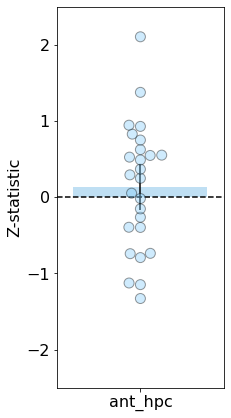

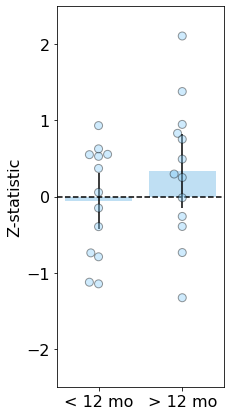

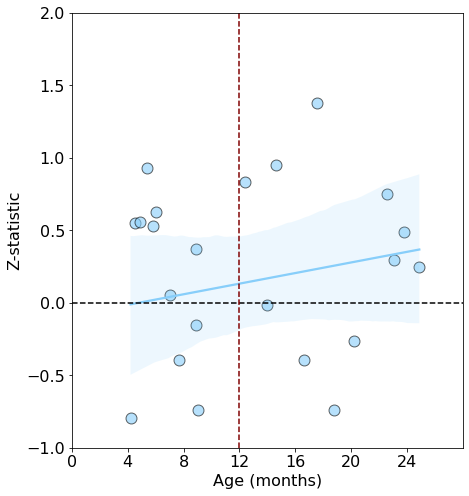

In [50]:
# Set random seed
np.random.seed(0)

# plot the results for ant hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(ant_hpc,roi_name='ant_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_ant_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_ant_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_ant_hpc_age.svg' %(save_plot_dir,condition)) 

Plotting contrast: Familiarity
post_hpc effect: 0.266 [0.040 - 0.521], p=0.014

Mean zstat younger: 0.002 [-0.280 - 0.277], p=0.946
Mean zstat  older: 0.530 [0.215 - 0.886], p=0.000
Younger vs. older infants: -0.529, p=0.010

Age effect: spearman rho =0.280 [-0.111 - 0.638], p=0.138


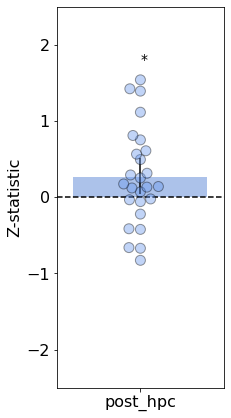

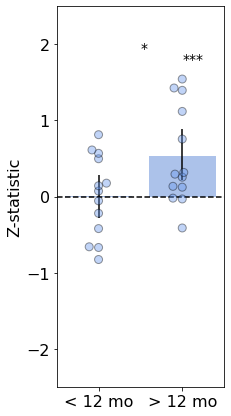

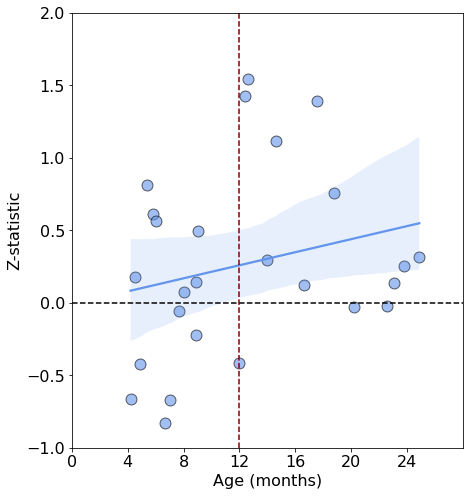

In [51]:
# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(post_hpc,roi_name='post_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_post_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_post_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_post_hpc_age.svg' %(save_plot_dir,condition)) 

## Strong vs. weak preferences <a id='nondirectional'></a>
Instead of looking at familiarity preferences, let's examine strong preferences in either direction versus weak preferences. To equate the number of trials in each bin, we set a cutoff such that strong preferences are between 0-29% OR 71-100% looking to the familiar item at test, whereas weak preferences are between 30-70% looking to the familiar item at test.

Running analysis for contrast: High Pref > Low Pref
Plotting contrast: High Pref > Low Pref
hpc effect: 0.052 [-0.355 - 0.455], p=0.750

Mean zstat younger: 0.291 [-0.301 - 0.865], p=0.332
Mean zstat  older: -0.188 [-0.697 - 0.326], p=0.476
Younger vs. older infants: 0.478, p=0.242

Age effect: spearman rho =-0.312 [-0.682 - 0.102], p=0.132


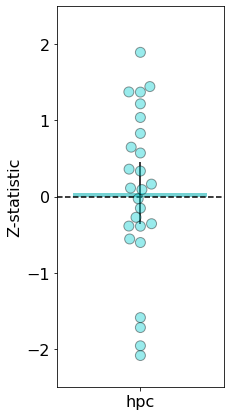

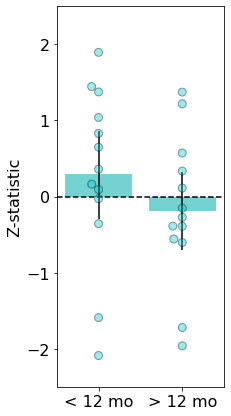

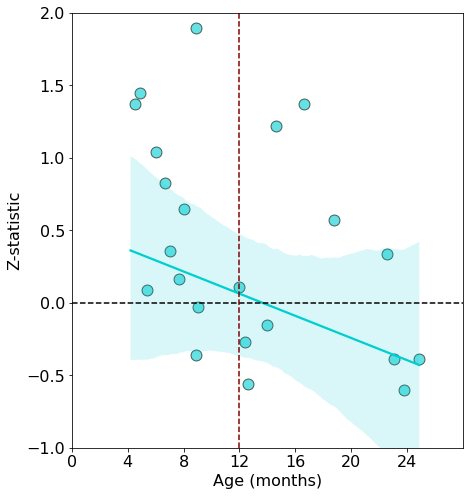

In [52]:
# what contrast and z-statistic? 
condition='LowHighPref'
z=4

# Run the analysis (i.e., get the z-stat files for each subject and mask by the hipp and mtl)
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results across hemispheres
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

# # save the figures
fig1.savefig('%s/%s_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_age.svg' %(save_plot_dir,condition))  


Plotting contrast: High Pref > Low Pref
ant_hpc effect: -0.052 [-0.423 - 0.320], p=0.808

Mean zstat younger: 0.177 [-0.363 - 0.695], p=0.522
Mean zstat  older: -0.282 [-0.779 - 0.201], p=0.244
Younger vs. older infants: 0.460, p=0.226

Age effect: spearman rho =-0.239 [-0.597 - 0.176], p=0.274
Plotting contrast: High Pref > Low Pref
post_hpc effect: 0.124 [-0.338 - 0.582], p=0.542

Mean zstat younger: 0.364 [-0.282 - 0.983], p=0.282
Mean zstat  older: -0.117 [-0.708 - 0.450], p=0.710
Younger vs. older infants: 0.481, p=0.304

Age effect: spearman rho =-0.274 [-0.657 - 0.137], p=0.198


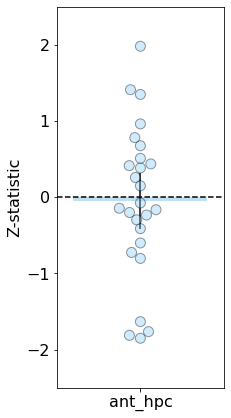

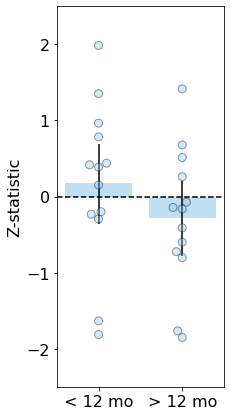

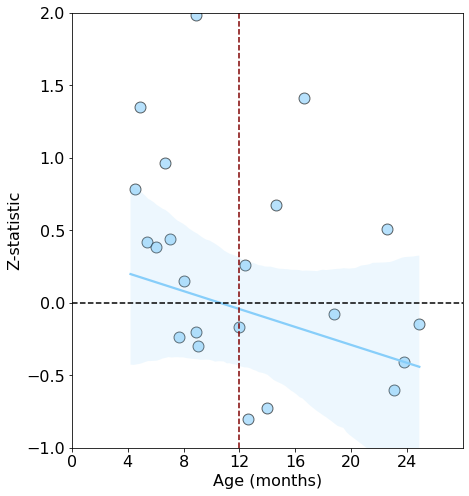

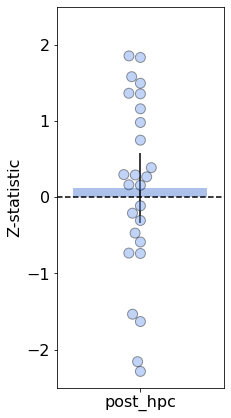

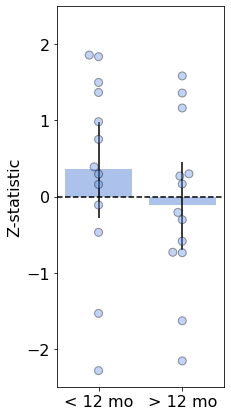

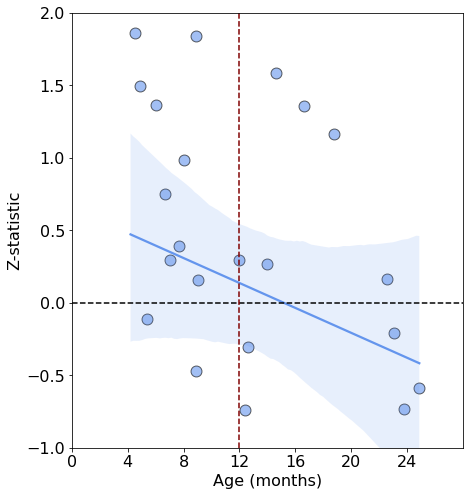

In [53]:
# Now let's look at the subregions of the hpc
# Run the analysis 
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)

# Set random seed
np.random.seed(0)

# plot the results for ant hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(ant_hpc,roi_name='ant_hpc',condition=condition,zstat=z)

# # save them 
fig1.savefig('%s/%s_ant_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_ant_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_ant_hpc_age.svg' %(save_plot_dir,condition)) 

# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(post_hpc,roi_name='post_hpc',condition=condition,zstat=z)

# # save them 
fig1.savefig('%s/%s_post_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_post_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_post_hpc_age.svg' %(save_plot_dir,condition)) 

## Memory retrieval results <a id='retrieval'></a>
We have focused mostly on memory encoding effects, but what is happening in the hippocampus during the test trials? 

#### First, lets look at the binary contrast (akin to our main results looking at familiarity preference vs. not) 

Running analysis for contrast: Fam Test > Nov Test
Plotting contrast: Fam Test > Nov Test
hpc effect: -0.003 [-0.282 - 0.304], p=0.992

Mean zstat younger: 0.013 [-0.495 - 0.475], p=0.960
Mean zstat  older: -0.020 [-0.335 - 0.363], p=0.924
Younger vs. older infants: 0.033, p=0.798

Age effect: spearman rho =-0.025 [-0.468 - 0.395], p=0.928


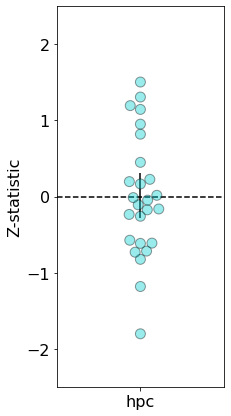

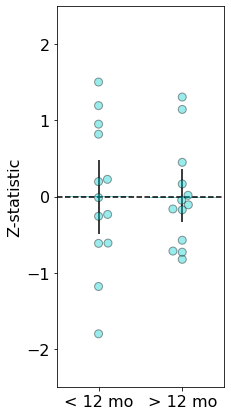

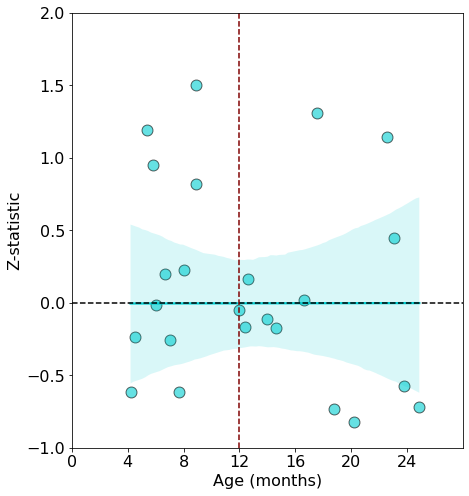

In [54]:
# what contrast and z-statistic? 
condition='Binary_Retrieval'
z=4

# Run the analysis (i.e., get the z-stat files for each subject and mask by the hipp and mtl)
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results across hemispheres
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

# save the figures
fig1.savefig('%s/%s_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_age.svg' %(save_plot_dir,condition))  

In [55]:
# Now let's look at the subregions of the hpc
# Run the analysis 
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)


Plotting contrast: Fam Test > Nov Test
ant_hpc effect: -0.017 [-0.350 - 0.339], p=0.938

Mean zstat younger: 0.090 [-0.508 - 0.608], p=0.734
Mean zstat  older: -0.124 [-0.530 - 0.345], p=0.604
Younger vs. older infants: 0.214, p=0.474

Age effect: spearman rho =-0.109 [-0.524 - 0.301], p=0.644


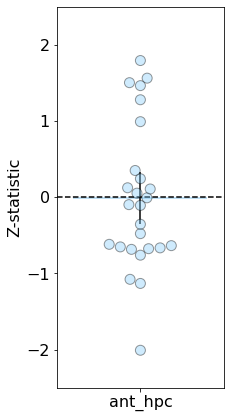

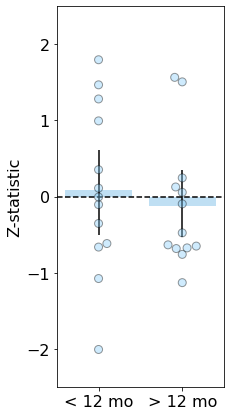

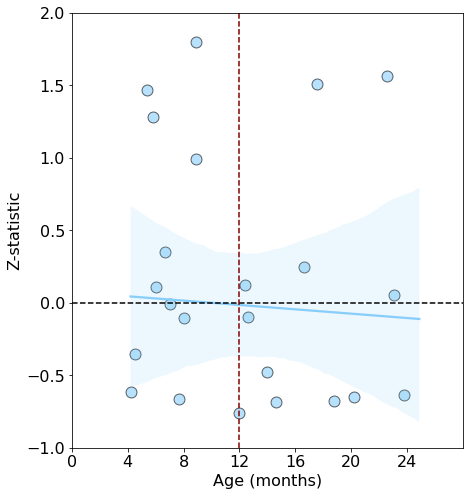

In [56]:
# Set random seed
np.random.seed(0)

# plot the results for ant hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(ant_hpc,roi_name='ant_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_ant_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_ant_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_ant_hpc_age.svg' %(save_plot_dir,condition)) 

Plotting contrast: Fam Test > Nov Test
post_hpc effect: 0.010 [-0.251 - 0.301], p=0.948

Mean zstat younger: -0.028 [-0.495 - 0.409], p=0.906
Mean zstat  older: 0.049 [-0.273 - 0.386], p=0.724
Younger vs. older infants: -0.077, p=0.876

Age effect: spearman rho =0.061 [-0.380 - 0.457], p=0.796


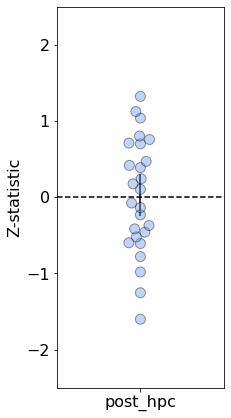

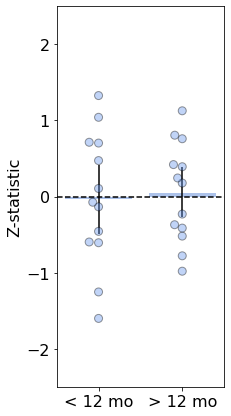

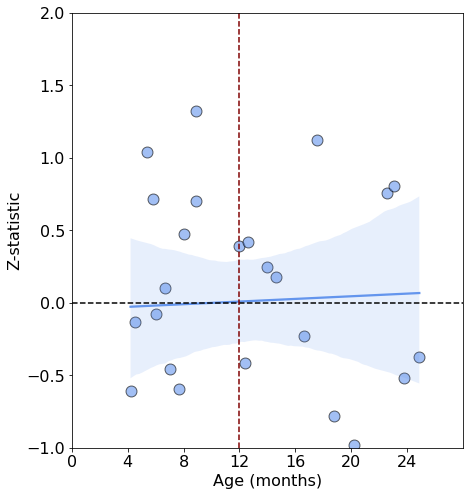

In [57]:
# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(post_hpc,roi_name='post_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_post_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_post_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_post_hpc_age.svg' %(save_plot_dir,condition)) 

#### Next, lets look at the parametric version

Running analysis for contrast: Familiarity Test
Plotting contrast: Familiarity Test
hpc effect: 0.041 [-0.240 - 0.339], p=0.790

Mean zstat younger: -0.091 [-0.647 - 0.423], p=0.740
Mean zstat  older: 0.174 [-0.117 - 0.477], p=0.226
Younger vs. older infants: -0.265, p=0.424

Age effect: spearman rho =0.022 [-0.420 - 0.475], p=0.956


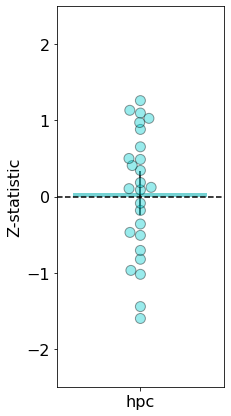

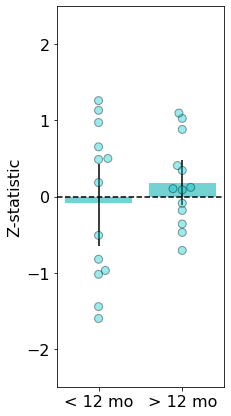

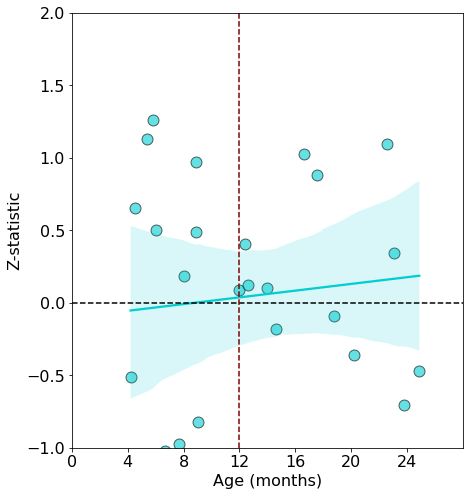

In [58]:
# what contrast and z-statistic? 
condition='Parametric_Retrieval'
z=1

# Run the analysis (i.e., get the z-stat files for each subject and mask by the hipp and mtl)
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results across hemispheres
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

# Set random seed
np.random.seed(0)

# plot the results for hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc,roi_name='hpc',condition=condition,zstat=z)

# save the figures
fig1.savefig('%s/%s_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_age.svg' %(save_plot_dir,condition))  

In [59]:
# Now let's look at the subregions of the hpc
# Run the analysis 
zstat_results=hpc_ant_post_results(condition=condition,zstat=z)

# Average the anterior hpc and posterior hpc results across hemispheres 
ant_hpc=np.nanmean(zstat_results[0],axis=1)
post_hpc=np.nanmean(zstat_results[1],axis=1)

Plotting contrast: Familiarity Test
ant_hpc effect: -0.002 [-0.318 - 0.367], p=0.986

Mean zstat younger: -0.050 [-0.629 - 0.514], p=0.862
Mean zstat  older: 0.046 [-0.363 - 0.476], p=0.802
Younger vs. older infants: -0.096, p=0.820

Age effect: spearman rho =0.022 [-0.399 - 0.466], p=0.922


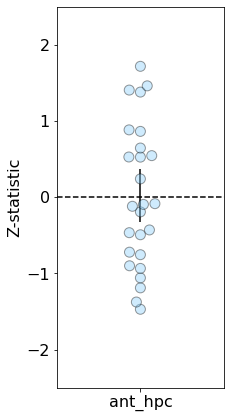

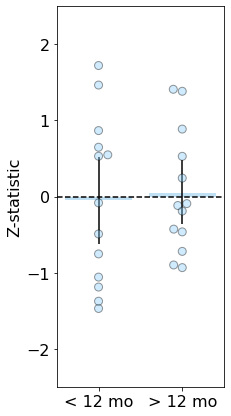

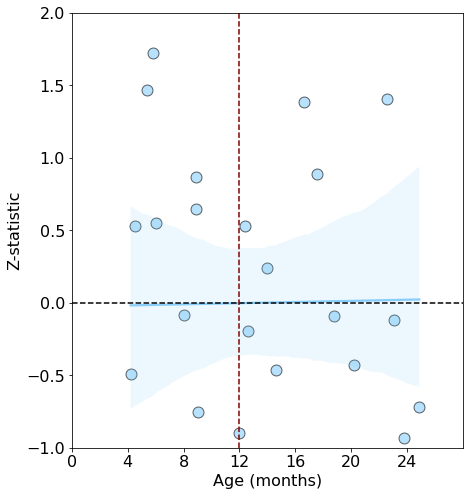

In [60]:
# Set random seed
np.random.seed(0)

# plot the results for ant hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(ant_hpc,roi_name='ant_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_ant_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_ant_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_ant_hpc_age.svg' %(save_plot_dir,condition)) 

Plotting contrast: Familiarity Test
post_hpc effect: 0.073 [-0.211 - 0.369], p=0.606

Mean zstat younger: -0.119 [-0.670 - 0.372], p=0.646
Mean zstat  older: 0.266 [0.023 - 0.508], p=0.036
Younger vs. older infants: -0.385, p=0.220

Age effect: spearman rho =0.074 [-0.403 - 0.518], p=0.778


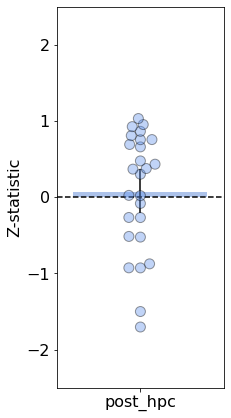

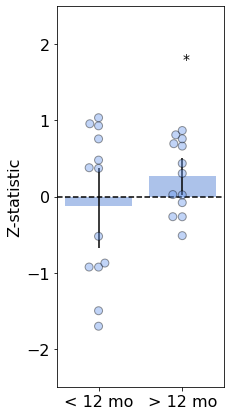

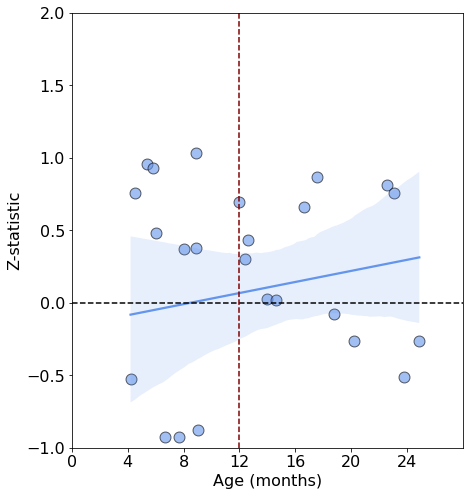

In [61]:
# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(post_hpc,roi_name='post_hpc',condition=condition,zstat=z)

# save them 
fig1.savefig('%s/%s_post_hpc_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_post_hpc_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_post_hpc_age.svg' %(save_plot_dir,condition)) 

# Control Analyses <a id='control'></a>
We found a strong age effect in our main analyses. Here, we rule out whether there may be confounds that caused this effect.

## Partial correlations <a id='partial_corr'></a>
Testing whether other factors, such as the proportion of usable data, may explain the age differences in hippocampal involvement in memory encoding. To do this, we run partial correlations accounting for the potential confound.

In [62]:
# what contrast and z-statistic? 
condition='Binary'
z=4

# Run the analysis! 
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results 
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

Running analysis for contrast: Fam > Nov


In [63]:
# rerun because you may have overwritten it above 
prop_fam_binary = [sum(np.array(looking_behavior[i]['prop_fam'])>0.5)/len(looking_behavior[i]['prop_fam']) 
 for i in looking_behavior.keys()]

In [64]:
# Get the size of the whole hippocampus in native space to see if anatomy can explain our results 
hpc_vols=[np.nansum(literal_eval(vals)[0:2]) for vals in anat_df['Volume']]

In [65]:
np.random.seed(0)

for covariate in ['prop_TR_included','Encode_Trials','prop_looking']:
    rval,pval,CIs=bootstrap_partial_corr(df.Age,hpc,df[covariate])
    print('Covariate: %s, r = %0.3f [%0.3f - %0.3f], p = %0.3f' %(covariate, rval,CIs[0],CIs[1],pval))
    
rval,pval,CIs=bootstrap_partial_corr(df.Age,hpc,prop_fam_binary)
print('Covariate: prop looking familiar, r = %0.3f [%0.3f - %0.3f], p = %0.3f' %(rval,CIs[0],CIs[1],pval))

rval,pval,CIs=bootstrap_partial_corr(df.Age,hpc,prop_encoding_usable)
print('Covariate: prop encoding usable, r = %0.3f [%0.3f - %0.3f], p = %0.3f' %(rval,CIs[0],CIs[1],pval))

rval,pval,CIs=bootstrap_partial_corr(df.Age,hpc,hpc_vols)
print('Covariate: hpc volume, r = %0.3f [%0.3f - %0.3f], p = %0.3f' %(rval,CIs[0],CIs[1],pval))

Covariate: prop_TR_included, r = 0.245 [-0.077 - 0.530], p = 0.057
Covariate: Encode_Trials, r = 0.341 [0.030 - 0.611], p = 0.018
Covariate: prop_looking, r = 0.288 [-0.024 - 0.618], p = 0.039
Covariate: prop looking familiar, r = 0.281 [-0.021 - 0.587], p = 0.033
Covariate: prop encoding usable, r = 0.312 [-0.052 - 0.673], p = 0.044
Covariate: hpc volume, r = 0.304 [0.022 - 0.553], p = 0.021


## HPC variance <a id='variance'></a>
Testing whether hippocampal variance could explain age effects, by calculating variance in the hippocampal signal after running a task versus rest analysis. 

In [66]:
# Run the analysis
resids_results=hpc_resids_analysis()

# Average the hpc and mtl results 
hpc_resids=np.nanmean(resids_results[0],axis=1)
mtl_resids=np.nanmean(resids_results[1],axis=1)

Plotting contrast: Encode > GIF
hpc effect: 0.899 [0.881 - 0.920], p=0.000

Mean zstat younger: 0.900 [0.865 - 0.934], p=0.000
Mean zstat  older: 0.899 [0.884 - 0.915], p=0.000
Younger vs. older infants: 0.000, p=0.994

Age effect: spearman rho =0.102 [-0.399 - 0.539], p=0.650


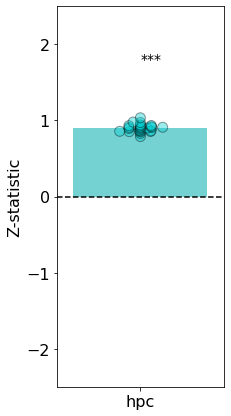

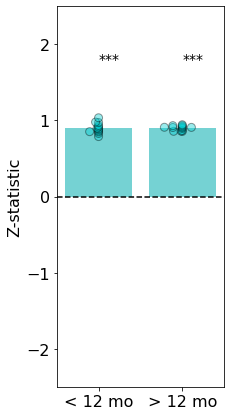

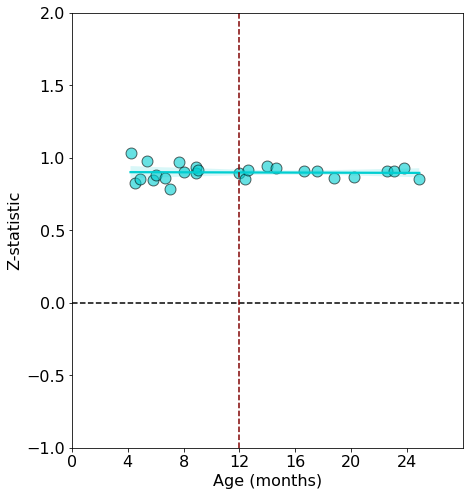

In [67]:
# Set random seed
np.random.seed(0)

# plot the results for post hpc (overall, split half age, continuous age)
fig1, fig2, fig3 = plot_roi_results(hpc_resids,roi_name='hpc',condition='Control',zstat=1)

# save them 
fig1.savefig('%s/%s_hpc_resids_all_results.svg' %(save_plot_dir,condition))
fig2.savefig('%s/%s_hpc_resids_split_half.svg' %(save_plot_dir,condition))
fig3.savefig('%s/%s_hpc_resids_age.svg' %(save_plot_dir,condition)) 

## Category activation <a id='category'></a>
As a measure of data quality, we can assess whether younger and older infants both show visual activation to preferred visual categories in different high level regions of interest. 

bilateral_FFA
Running analysis for contrast: Face > GIF
Plotting contrast: Face > GIF
bilateral_FFA effect: 0.979 [0.463 - 1.534], p=0.000

Mean zstat younger: 1.141 [0.308 - 2.092], p=0.004
Mean zstat  older: 0.816 [0.261 - 1.447], p=0.008
Younger vs. older infants: 0.324, p=0.588

Age effect: spearman rho =-0.229 [-0.574 - 0.190], p=0.270

bilateral_OOA
Running analysis for contrast: Object > GIF
Plotting contrast: Object > GIF
bilateral_OOA effect: 1.227 [0.868 - 1.600], p=0.000

Mean zstat younger: 1.400 [0.893 - 1.922], p=0.000
Mean zstat  older: 1.054 [0.585 - 1.519], p=0.000
Younger vs. older infants: 0.346, p=0.362

Age effect: spearman rho =-0.282 [-0.673 - 0.122], p=0.194

bilateral_PPA
Running analysis for contrast: Place > GIF
Plotting contrast: Place > GIF
bilateral_PPA effect: 1.526 [1.051 - 2.041], p=0.000

Mean zstat younger: 1.589 [0.823 - 2.585], p=0.000
Mean zstat  older: 1.464 [0.917 - 1.984], p=0.000
Younger vs. older infants: 0.125, p=0.834

Age effect: spearman r

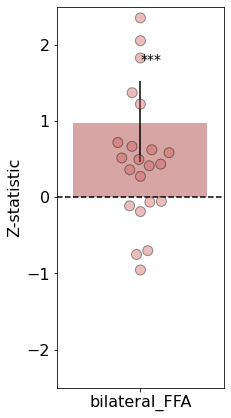

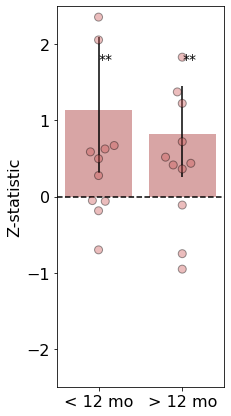

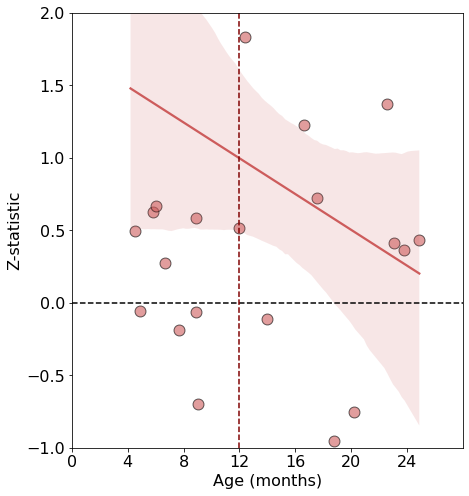

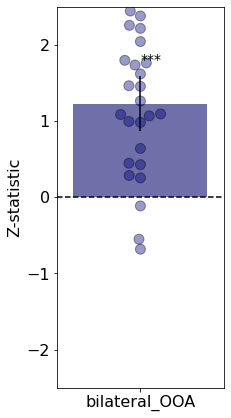

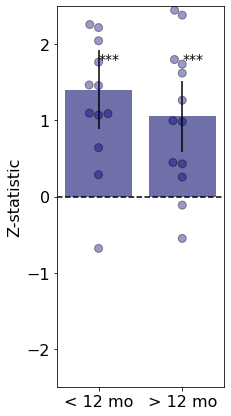

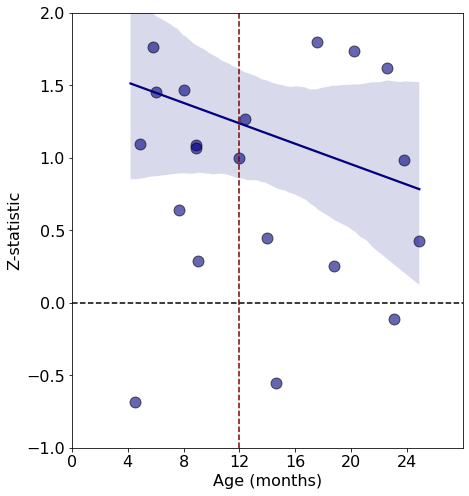

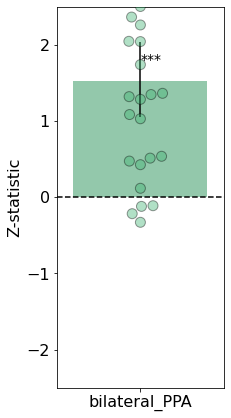

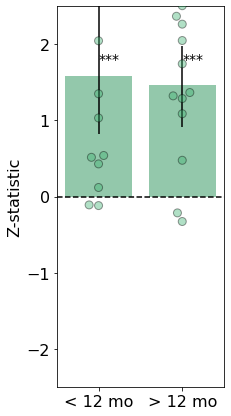

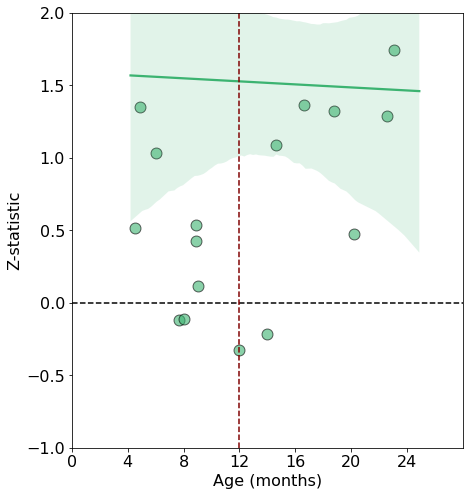

In [68]:
# what contrast and z-statistic? 
condition='Task'

# Set random seed
np.random.seed(0)

for z, roi_name, cat in zip([2,3,4],['bilateral_FFA','bilateral_OOA','bilateral_PPA'],
                      ['faces','objects','places']):
    print(roi_name)
    temp_zstats = other_roi_results(condition,zstat=z,roi_name=roi_name)
    
    # plot the results for post hpc (overall, split half age, continuous age)
    fig1, fig2, fig3 = plot_roi_results(temp_zstats,roi_name=roi_name,condition=condition,zstat=z)

    # save them 
    fig1.savefig('%s/%s_%s_%s_all_results.svg' %(save_plot_dir,condition,roi_name,cat))
    fig2.savefig('%s/%s_%s_%s_split_half.svg' %(save_plot_dir,condition,roi_name,cat))
    fig3.savefig('%s/%s_%s_%s_age.svg' %(save_plot_dir,condition,roi_name,cat)) 
    
    print()

## Unique images <a id='unique'></a>
Finally, a bug in our experiment code meant that 5 infants saw some of the same images from a previous fMRI session on a later visit. Here we see that not including those trials in which infants were tested on previously-encountered images does not change our results. 

In [69]:
# what contrast and z-statistic? 
condition='Binary'
z=4

# Run the analysis for all images that were shown 
zstat_results=hpc_results(condition=condition,zstat=z)

# Average the hpc and mtl results 
hpc=np.nanmean(zstat_results[0],axis=1)
mtl=np.nanmean(zstat_results[1],axis=1)

# Run the analysis (except now, the 5 repeat sessions where there were some repeat images, we remove those trials)
zstat_results_unique=hpc_results(condition='Binary_Unique',zstat=z)

# Average the hpc and mtl results 
hpc_unique=np.nanmean(zstat_results_unique[0],axis=1)
mtl_unique=np.nanmean(zstat_results_unique[1],axis=1)


Running analysis for contrast: Fam > Nov
Running analysis for contrast: Fam > Nov


All vs. unique images: -0.234, p=0.496


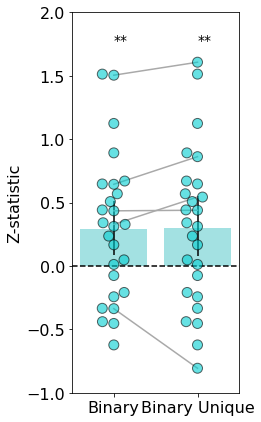

In [70]:
np.random.seed(0)

fig=plt.figure(figsize=(3,7))

xvals=np.hstack((np.zeros(len(df.Ppt)),np.ones(len(df.Ppt))))

# fill in the values for the non-problem subs
hpc_unique_temp=np.copy(hpc_unique)
for v, val in enumerate(hpc_unique):
    if np.isnan(val):
        hpc_unique_temp[v]=hpc[v]

sns.swarmplot(x=xvals,y=np.hstack((hpc,hpc_unique_temp)),dodge=False,
              color='darkturquoise',size=10,alpha=0.6,edgecolor='black',linewidth=1)
sns.barplot(x=xvals,y=np.hstack((hpc,hpc_unique_temp)),dodge=False,alpha=0.4,
            color='darkturquoise',ci=None)

# plot the lines between the two to show how the effects changed with the remove of repeat images 
for v, val in enumerate(hpc_unique):
    if ~np.isnan(val):
        plt.plot([0,1],[hpc[v],val],color='darkgrey')


plt.axhline(0,linestyle='dashed',color='k')
plt.legend([],[], frameon=False)
plt.xticks([0,1],['Binary','Binary Unique'],fontsize=16)
plt.ylabel('Z-statistic',fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-1,2)

# draw the error bars 
p_val, CIs= bootstrap_mean(hpc)             
draw_sig(p_val,1,0,1.75)
plt.errorbar(0,np.nanmean(hpc),yerr=np.vstack((np.nanmean(hpc)-CIs[0],
                                                           CIs[1]-np.nanmean(hpc))),color='black')

p_val, CIs= bootstrap_mean(hpc_unique_temp)     
draw_sig(p_val,1,1,1.75)
plt.errorbar(1,np.nanmean(hpc_unique_temp),yerr=np.vstack((np.nanmean(hpc_unique_temp)-CIs[0],
                                                         CIs[1]-np.nanmean(hpc_unique_temp))),color='black')

# stats
p_val, mean_diff, CIs= randomise_diff_2sample(hpc,hpc_unique)             
print('All vs. unique images: %0.3f, p=%0.3f' %(mean_diff,p_val))
draw_sig(p_val,1,0.5,1.9)
    
fig.savefig('%s/hpc_unique_results_all_ppts.svg' %(save_plot_dir))